In [33]:
# Data Manipulation and Preparation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Evaluation metrics and visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

# Ensure GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

import itertools
import time
import csv
import json
from IPython.display import Audio, display
import winsound
from threading import Thread

Using device: cuda


In [2]:
# Load cleaned dataset
df = pd.read_csv('BTC_1h_Complete_NoTA.csv', parse_dates=['open_time'])

In [3]:
# Convert to datetime 
df['open_time'] = pd.to_datetime(df['open_time'])
df['close_time'] = pd.to_datetime(df['close_time'])

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def directional_accuracy(y_true, y_pred):
    return np.mean(np.sign(y_true[1:] - y_true[:-1]) == np.sign(y_pred[1:] - y_pred[:-1]))


In [30]:
def create_sequences(data, target, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        label = target[i + window_size]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

def prepare_data(df, target_column, window_size, feature_columns):
    X = df[feature_columns].values
    y = df[target_column].values.reshape(-1, 1)
    
    scaler_X = MinMaxScaler()
    X_scaled = scaler_X.fit_transform(X)

    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False)
    X_train_seq, y_train_seq = create_sequences(X_train, y_train, window_size)
    X_test_seq, y_test_seq = create_sequences(X_test, y_test, window_size)

    return X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y

class LSTMModel(nn.Module):
    def __init__(self, input_dim, lstm_dim, dense_dim, output_dim, num_layers=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_dim, num_layers=num_layers, batch_first=True, dropout=(dropout if num_layers > 1 else 0))
        self.fc1 = nn.Linear(lstm_dim, dense_dim)
        self.activation = nn.Tanh()
        self.fc2 = nn.Linear(dense_dim, output_dim)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

def train_and_evaluate(df, target_column, feature_columns, params, file_prefix='results', use_early_stopping=True, plot_loss=False):
    result = {}  # Initialize result to ensure it's always defined
    try:
        # Extract parameters
        window_size = params['window_size']
        lstm_dim = params['lstm_dim']
        dense_dim = params['dense_dim']
        num_layers = params['num_layers']
        dropout = params['dropout']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']
        optimizer_type = params['optimizer_type']
        patience = params['patience']

        # Clear CUDA cache
        torch.cuda.empty_cache()

        # Prepare data
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y = prepare_data(df, target_column, window_size, feature_columns)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)
        y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        # Model parameters
        input_dim = X_train_tensor.shape[2]
        output_dim = 1

        model = LSTMModel(input_dim, lstm_dim, dense_dim, output_dim, num_layers, dropout).to(device)

        # Define loss and optimizer
        criterion = nn.MSELoss()
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=lr)

        # Training loop
        best_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        training_losses = []
        validation_losses = []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(train_loader)
            training_losses.append(epoch_train_loss)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()

            val_loss /= len(test_loader)
            validation_losses.append(val_loss)

            if use_early_stopping:
                if val_loss < best_loss:
                    best_loss = val_loss
                    patience_counter = 0
                    torch.save(model.state_dict(), f'{file_prefix}_{target_column}_best_model.pth')
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        break

        training_time = time.time() - start_time

        # Save the final model if early stopping was not used or not triggered
        if not use_early_stopping or patience_counter < patience:
            torch.save(model.state_dict(), f'{file_prefix}_{target_column}_final_model.pth')

        # Evaluate the model
        model.eval()
        evaluation_start_time = time.time()
        with torch.no_grad():
            train_predictions = model(X_train_tensor).cpu().numpy()
            test_predictions = model(X_test_tensor).cpu().numpy()

            # Inverse transform predictions and actual values
            y_train_seq = y_train_seq.reshape(-1, 1)
            y_test_seq = y_test_seq.reshape(-1, 1)
            train_predictions_inverse = scaler_y.inverse_transform(train_predictions)
            test_predictions_inverse = scaler_y.inverse_transform(test_predictions)
            y_train_inverse = scaler_y.inverse_transform(y_train_seq)
            y_test_inverse = scaler_y.inverse_transform(y_test_seq)

            # # Invert log transformation
            # train_predictions_inverse = np.exp(train_predictions_inverse) - 1
            # test_predictions_inverse = np.exp(test_predictions_inverse) - 1
            # y_train_inverse = np.exp(y_train_inverse) - 1
            # y_test_inverse = np.exp(y_test_inverse) - 1

            train_mse = mean_squared_error(y_train_inverse, train_predictions_inverse)
            test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
            train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
            test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
            train_rmse = np.sqrt(train_mse)
            test_rmse = np.sqrt(test_mse)
            train_r2 = r2_score(y_train_inverse, train_predictions_inverse)
            test_r2 = r2_score(y_test_inverse, test_predictions_inverse)

            train_mape = np.mean(np.abs((y_train_inverse - train_predictions_inverse) / y_train_inverse)) * 100
            test_mape = np.mean(np.abs((y_test_inverse - test_predictions_inverse) / y_test_inverse)) * 100

            train_directional_acc = np.mean(np.sign(y_train_inverse[1:] - y_train_inverse[:-1]) == np.sign(train_predictions_inverse[1:] - train_predictions_inverse[:-1]))
            test_directional_acc = np.mean(np.sign(y_test_inverse[1:] - y_test_inverse[:-1]) == np.sign(test_predictions_inverse[1:] - test_predictions_inverse[:-1]))

        evaluation_time = time.time() - evaluation_start_time

        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim": dense_dim,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "train_mse": train_mse,
            "test_mse": test_mse,
            "train_mae": train_mae,
            "test_mae": test_mae,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "train_mape": train_mape,
            "test_mape": test_mape,
            "train_directional_acc": train_directional_acc,
            "test_directional_acc": test_directional_acc,
            "training_time": training_time,
            "evaluation_time": evaluation_time,
            "patience": patience
        }

        # Save result to a CSV file
        with open(f'{file_prefix}_{target_column}.csv', 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=result.keys())
            if f.tell() == 0:
                writer.writeheader()  # Write header only if file is empty
            writer.writerow(result)

        # # Save training and validation losses to a JSON file
        # losses = {
        #     "training_losses": training_losses,
        #     "validation_losses": validation_losses
        # }
        # with open(f'{file_prefix}_{target_column}_losses.json', 'w') as f:
        #     json.dump(losses, f)

        # # Save predictions and actual values to a JSON file
        # predictions = {
        #     "train_predictions": train_predictions_inverse.tolist(),
        #     "test_predictions": test_predictions_inverse.tolist(),
        #     "y_train": y_train_inverse.tolist(),
        #     "y_test": y_test_inverse.tolist()
        # }
        # with open(f'{file_prefix}_{target_column}_predictions.json', 'w') as f:
        #     json.dump(predictions, f)

        # # Save hyperparameters to a JSON file, excluding any non-serializable types
        # serializable_params = {k: v for k, v in params.items() if isinstance(v, (int, float, str, bool))}
        # with open(f'{file_prefix}_{target_column}_params.json', 'w') as f:
        #     json.dump(serializable_params, f)

        # Print summary of the results
        print(f"Results: Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
        print(f"Train DA: {train_directional_acc:.4f}, Test DA: {test_directional_acc:.4f}")
        print(f"Training Time: {training_time:.4f} seconds, Evaluation Time: {evaluation_time:.4f} seconds\n")

        # Plot loss over epochs if specified
        if plot_loss:
            plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=3)

    except Exception as e:
        print(f"An error occurred: {e}")
        # Ensure result is always defined, even in case of error
        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim": dense_dim,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "error": str(e)
        }

    return result

In [9]:
# Define parameter space
parameter_space = {
    'window_size': [24],
    'lstm_dim': [25, 60, 100],
    'dense_dim': [25, 60, 100],
    'num_layers': [2],
    'dropout': [0.001],
    'lr': [0.0001],
    'num_epochs': [100, 200],
    'batch_size': [64],
    'optimizer_type': ['Adam'],
    'patience': [24],
    'activation_function': [nn.Tanh]
}


In [10]:
# Define target column
target_column = ['close']

# Define feature combination
features = ['open', 'high', 'low', 'close', 'volume',
       'quote_vol', 'count', 'buy_base', 'buy_quote', 'open_p', 'high_p', 'low_p', 'close_p']

In [11]:
# Grid search
for params in itertools.product(*parameter_space.values()):
    param_dict = dict(zip(parameter_space.keys(), params))
    print(f"Running model with parameters: {param_dict}\n")
    # Run with fixed epochs
    print('Results:\n')
    train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete11', use_early_stopping=False, plot_loss=False)


Running model with parameters: {'window_size': 24, 'lstm_dim': 25, 'dense_dim': 25, 'num_layers': 2, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 174.1512, Test MAE: 165.2430
Train MAPE: 0.6040, Test MAPE: 0.3652
Train DA: 0.4684, Test DA: 0.4718
Training Time: 108.8550 seconds, Evaluation Time: 0.0423 seconds

Running model with parameters: {'window_size': 24, 'lstm_dim': 25, 'dense_dim': 25, 'num_layers': 2, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 188.9083, Test MAE: 234.2663
Train MAPE: 0.6970, Test MAPE: 0.5419
Train DA: 0.4737, Test DA: 0.4688
Training Time: 216.7021 seconds, Evaluation Time: 0.0462 seconds

Running model with parameters: {'window_size':

In [12]:
# Define parameter space
parameter_space = {
    'window_size': [24],
    'lstm_dim': [20, 40, 60],
    'dense_dim': [20, 40, 60],
    'num_layers': [3],
    'dropout': [0.001],
    'lr': [0.0001],
    'num_epochs': [100, 200],
    'batch_size': [64],
    'optimizer_type': ['Adam'],
    'patience': [24],
    'activation_function': [nn.Tanh]
}


In [13]:
# Grid search
for params in itertools.product(*parameter_space.values()):
    param_dict = dict(zip(parameter_space.keys(), params))
    print(f"Running model with parameters: {param_dict}\n")
    # Run with fixed epochs
    print('Results:\n')
    train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete12', use_early_stopping=False, plot_loss=False)


Running model with parameters: {'window_size': 24, 'lstm_dim': 20, 'dense_dim': 20, 'num_layers': 3, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 224.6923, Test MAE: 211.0231
Train MAPE: 0.9441, Test MAPE: 0.4543
Train DA: 0.4637, Test DA: 0.4561
Training Time: 115.9268 seconds, Evaluation Time: 0.0517 seconds

Running model with parameters: {'window_size': 24, 'lstm_dim': 20, 'dense_dim': 20, 'num_layers': 3, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 183.2668, Test MAE: 175.3690
Train MAPE: 0.7495, Test MAPE: 0.3785
Train DA: 0.4715, Test DA: 0.4709
Training Time: 230.7026 seconds, Evaluation Time: 0.0403 seconds

Running model with parameters: {'window_size':

In [16]:
# Define parameter space
parameter_space = {
    'window_size': [24],
    'lstm_dim': [50, 75, 100],
    'dense_dim': [50, 75, 100],
    'num_layers': [4],
    'dropout': [0.001],
    'lr': [0.0001],
    'num_epochs': [100, 200, 300],
    'batch_size': [64],
    'optimizer_type': ['Adam'],
    'patience': [24],
    'activation_function': [nn.Tanh]
}


In [17]:
# Grid search
for params in itertools.product(*parameter_space.values()):
    param_dict = dict(zip(parameter_space.keys(), params))
    print(f"Running model with parameters: {param_dict}\n")
    # Run with fixed epochs
    print('Results:\n')
    train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete13', use_early_stopping=False, plot_loss=False)


Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 50, 'num_layers': 4, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 100, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 215.1005, Test MAE: 235.5709
Train MAPE: 0.9288, Test MAPE: 0.4938
Train DA: 0.4717, Test DA: 0.4697
Training Time: 117.1873 seconds, Evaluation Time: 0.0998 seconds

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 50, 'num_layers': 4, 'dropout': 0.001, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 195.6571, Test MAE: 228.6235
Train MAPE: 0.7805, Test MAPE: 0.5138
Train DA: 0.4747, Test DA: 0.4707
Training Time: 233.0881 seconds, Evaluation Time: 0.1050 seconds

Running model with parameters: {'window_size':

In [19]:
# class FlexibleLSTMModel(nn.Module):
#     def __init__(self, layer_configs):
#         super(FlexibleLSTMModel, self).__init__()

#         self.layers = nn.ModuleList()
#         for i, layer_config in enumerate(layer_configs):
#             input_dim = layer_config['input_dim']
#             output_dim = layer_config['output_dim']
#             num_layers = layer_config['num_layers']
#             dropout = layer_config['dropout']
#             activation_function = layer_config['activation_function']

#             lstm_layer = nn.LSTM(input_dim, output_dim, num_layers=num_layers, batch_first=True, dropout=(dropout if num_layers > 1 else 0))
#             dense_layer = nn.Linear(output_dim, output_dim)
#             activation = activation_function()

#             self.layers.append(nn.ModuleDict({
#                 'lstm': lstm_layer,
#                 'dense': dense_layer,
#                 'activation': activation
#             }))

#     def forward(self, x):
#         for layer in self.layers:
#             x, _ = layer['lstm'](x)
#             x = x[:, -1, :]
#             x = layer['dense'](x)
#             x = layer['activation'](x)
#         return x

# def get_activation_function(name):
#     if name == 'ReLU':
#         return nn.ReLU
#     elif name == 'Tanh':
#         return nn.Tanh
#     elif name == 'Sigmoid':
#         return nn.Sigmoid
#     else:
#         raise ValueError(f"Unsupported activation function: {name}")

In [25]:
# def train_and_evaluate(df, target_column, feature_columns, params, file_prefix='results', use_early_stopping=True, plot_loss=False, log_transform=False):
#     result = {}  # Initialize result to ensure it's always defined
#     try:
#         # Extract parameters
#         window_size = params['window_size']
#         layer_configs = params['layer_configs']
#         lr = params['lr']
#         batch_size = params['batch_size']
#         num_epochs = params['num_epochs']
#         optimizer_type = params['optimizer_type']
#         patience = params['patience']

#         # Clear CUDA cache
#         torch.cuda.empty_cache()

#         # Prepare data
#         X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y = prepare_data(df, target_column, window_size, feature_columns, log_transform=log_transform)

#         # Convert to PyTorch tensors
#         X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
#         X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
#         y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)
#         y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

#         # Create data loaders
#         train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
#         test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
#         train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
#         test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#         # Model parameters
#         for i, layer_config in enumerate(layer_configs):
#             if i == 0:
#                 layer_config['input_dim'] = X_train_tensor.shape[2]
#             else:
#                 layer_config['input_dim'] = layer_configs[i - 1]['output_dim']

#         model = FlexibleLSTMModel(layer_configs).to(device)

#         # Define loss and optimizer
#         criterion = nn.MSELoss()
#         optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=lr)

#         # Training loop
#         best_loss = float('inf')
#         patience_counter = 0
#         start_time = time.time()

#         training_losses = []
#         validation_losses = []

#         for epoch in range(num_epochs):
#             model.train()
#             epoch_train_loss = 0
#             for inputs, labels in train_loader:
#                 optimizer.zero_grad()
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)
#                 loss.backward()
#                 optimizer.step()
#                 epoch_train_loss += loss.item()

#             epoch_train_loss /= len(train_loader)
#             training_losses.append(epoch_train_loss)

#             model.eval()
#             val_loss = 0
#             with torch.no_grad():
#                 for inputs, labels in test_loader:
#                     outputs = model(inputs)
#                     val_loss += criterion(outputs, labels).item()

#             val_loss /= len(test_loader)
#             validation_losses.append(val_loss)

#             # if use_early_stopping:
#             #     if val_loss < best_loss:
#             #         best_loss = val_loss
#             #         patience_counter = 0
#             #         torch.save(model.state_dict(), f'{file_prefix}_{target_column}_best_model.pth')
#             #     else:
#             #         patience_counter += 1
#             #         if patience_counter >= patience:
#                         # break

#         training_time = time.time() - start_time

#         # # Save the final model if early stopping was not used or not triggered
#         # if not use_early_stopping or patience_counter < patience:
#         #     torch.save(model.state_dict(), f'{file_prefix}_{target_column}_final_model.pth')

#         # Evaluate the model
#         model.eval()
#         evaluation_start_time = time.time()
#         with torch.no_grad():
#             train_predictions = model(X_train_tensor).cpu().numpy()
#             test_predictions = model(X_test_tensor).cpu().numpy()

#             # Inverse transform predictions and actual values
#             y_train_seq = y_train_seq.reshape(-1, 1)
#             y_test_seq = y_test_seq.reshape(-1, 1)
#             train_predictions_inverse = scaler_y.inverse_transform(train_predictions)
#             test_predictions_inverse = scaler_y.inverse_transform(test_predictions)
#             y_train_inverse = scaler_y.inverse_transform(y_train_seq)
#             y_test_inverse = scaler_y.inverse_transform(y_test_seq)

#             # if log_transform:
#             #     # Invert log transformation
#             #     train_predictions_inverse = np.exp(train_predictions_inverse) - 1
#             #     test_predictions_inverse = np.exp(test_predictions_inverse) - 1
#             #     y_train_inverse = np.exp(y_train_inverse) - 1
#             #     y_test_inverse = np.exp(y_test_inverse) - 1

#             train_mse = mean_squared_error(y_train_inverse, train_predictions_inverse)
#             test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
#             train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
#             test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
#             train_rmse = np.sqrt(train_mse)
#             test_rmse = np.sqrt(test_mse)
#             train_r2 = r2_score(y_train_inverse, train_predictions_inverse)
#             test_r2 = r2_score(y_test_inverse, test_predictions_inverse)

#             train_mape = np.mean(np.abs((y_train_inverse - train_predictions_inverse) / y_train_inverse)) * 100
#             test_mape = np.mean(np.abs((y_test_inverse - test_predictions_inverse) / y_test_inverse)) * 100

#             train_directional_acc = np.mean(np.sign(y_train_inverse[1:] - y_train_inverse[:-1]) == np.sign(train_predictions_inverse[1:] - train_predictions_inverse[:-1]))
#             test_directional_acc = np.mean(np.sign(y_test_inverse[1:] - y_test_inverse[:-1]) == np.sign(test_predictions_inverse[1:] - test_predictions_inverse[:-1]))

#         evaluation_time = time.time() - evaluation_start_time

#         result = {
#             "window_size": window_size,
#             "layer_configs": layer_configs,
#             "lr": lr,
#             "batch_size": batch_size,
#             "num_epochs": num_epochs,
#             "optimizer_type": optimizer_type,
#             "train_mse": train_mse,
#             "test_mse": test_mse,
#             "train_mae": train_mae,
#             "test_mae": test_mae,
#             "train_rmse": train_rmse,
#             "test_rmse": test_rmse,
#             "train_r2": train_r2,
#             "test_r2": test_r2,
#             "train_mape": train_mape,
#             "test_mape": test_mape,
#             "train_directional_acc": train_directional_acc,
#             "test_directional_acc": test_directional_acc,
#             "training_time": training_time,
#             "evaluation_time": evaluation_time,
#             "patience": patience
#         }

#         # Save result to a CSV file
#         with open(f'{file_prefix}_{target_column}.csv', 'a', newline='') as f:
#             writer = csv.DictWriter(f, fieldnames=result.keys())
#             if f.tell() == 0:
#                 writer.writeheader()  # Write header only if file is empty
#             writer.writerow(result)

#         # # Save training and validation losses to a JSON file
#         # losses = {
#         #     "training_losses": training_losses,
#         #     "validation_losses": validation_losses
#         # }
#         # with open(f'{file_prefix}_{target_column}_losses.json', 'w') as f:
#         #     json.dump(losses, f)

#         # # Save predictions and actual values to a JSON file
#         # predictions = {
#         #     "train_predictions": train_predictions_inverse.tolist(),
#         #     "test_predictions": test_predictions_inverse.tolist(),
#         #     "y_train": y_train_inverse.tolist(),
#         #     "y_test": y_test_inverse.tolist()
#         # }
#         # with open(f'{file_prefix}_{target_column}_predictions.json', 'w') as f:
#         #     json.dump(predictions, f)

#         # # Save hyperparameters to a JSON file, excluding any non-serializable types
#         # serializable_params = {k: v for k, v in params.items() if isinstance(v, (int, float, str, bool))}
#         # with open(f'{file_prefix}_{target_column}_params.json', 'w') as f:
#         #     json.dump(serializable_params, f)

#         # Print summary of the results
#         print(f"Finished model with parameters: {params}")
#         print(f"Results: Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}, Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
#         print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}, Train R2: {train_r2:.4f}, Test R2: {test_r2:.4f}")
#         print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
#         print(f"Train Directional Accuracy: {train_directional_acc:.4f}, Test Directional Accuracy: {test_directional_acc:.4f}")
#         print(f"Training Time: {training_time:.4f} seconds, Evaluation Time: {evaluation_time:.4f} seconds\n")

#         # Plot loss over epochs if specified
#         if plot_loss:
#             plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=3)

#     except Exception as e:
#         print(f"An error occurred: {e}")
#         # Ensure result is always defined, even in case of error
#         result = {
#             "window_size": window_size,
#             "layer_configs": layer_configs,
#             "lr": lr,
#             "batch_size": batch_size,
#             "num_epochs": num_epochs,
#             "optimizer_type": optimizer_type,
#             "error": str(e)
#         }

#     return result


In [26]:
def plot_loss_over_epochs(training_loss, validation_loss, file_prefix, start_epoch=3):
    plt.figure(figsize=(10, 6))
    plt.plot(range(start_epoch, len(training_loss)), training_loss[start_epoch:], label='Training Loss')
    plt.plot(range(start_epoch, len(validation_loss)), validation_loss[start_epoch:], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 160.8726, Test MAE: 148.0453
Train MAPE: 0.6534, Test MAPE: 0.3256
Train DA: 0.4730, Test DA: 0.4693
Training Time: 207.7451 seconds, Evaluation Time: 0.0811 seconds



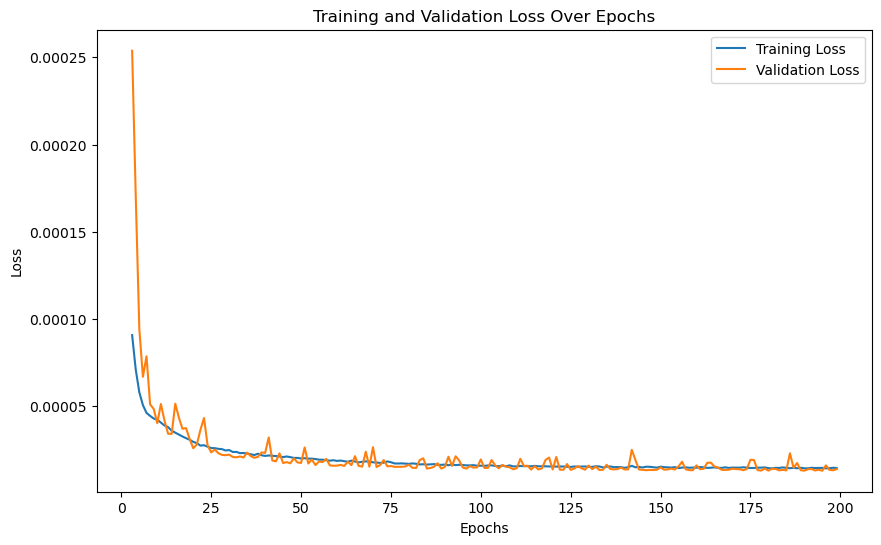

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 152.5230, Test MAE: 145.6955
Train MAPE: 0.5744, Test MAPE: 0.3270
Train DA: 0.4707, Test DA: 0.4716
Training Time: 420.4889 seconds, Evaluation Time: 0.1797 seconds



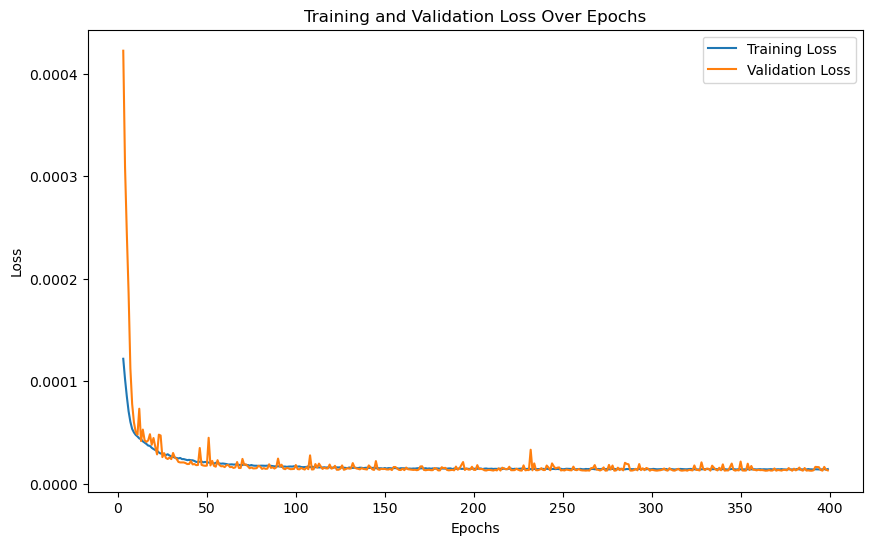

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 146.5754, Test MAE: 143.1157
Train MAPE: 0.5116, Test MAPE: 0.3157
Train DA: 0.4696, Test DA: 0.4710
Training Time: 210.5492 seconds, Evaluation Time: 0.0677 seconds



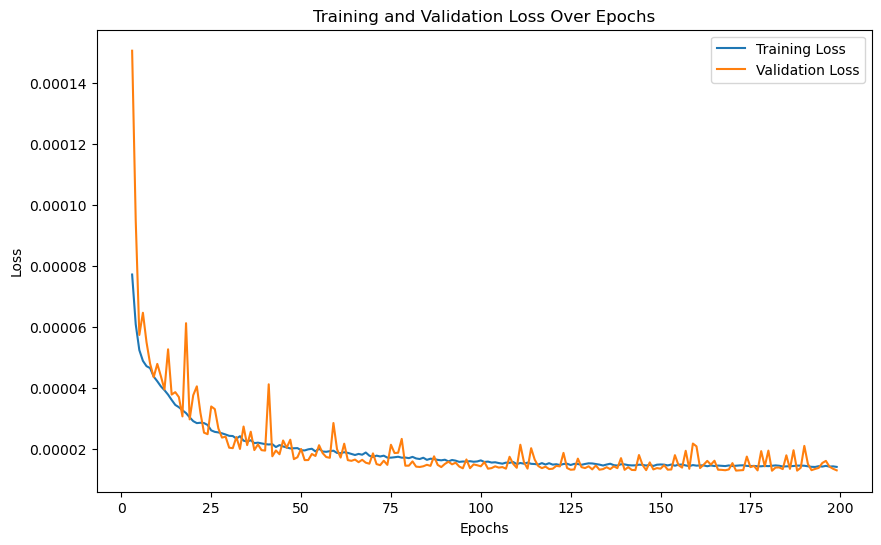

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 142.3000, Test MAE: 139.5205
Train MAPE: 0.4786, Test MAPE: 0.3065
Train DA: 0.4693, Test DA: 0.4704
Training Time: 428.7416 seconds, Evaluation Time: 0.0792 seconds



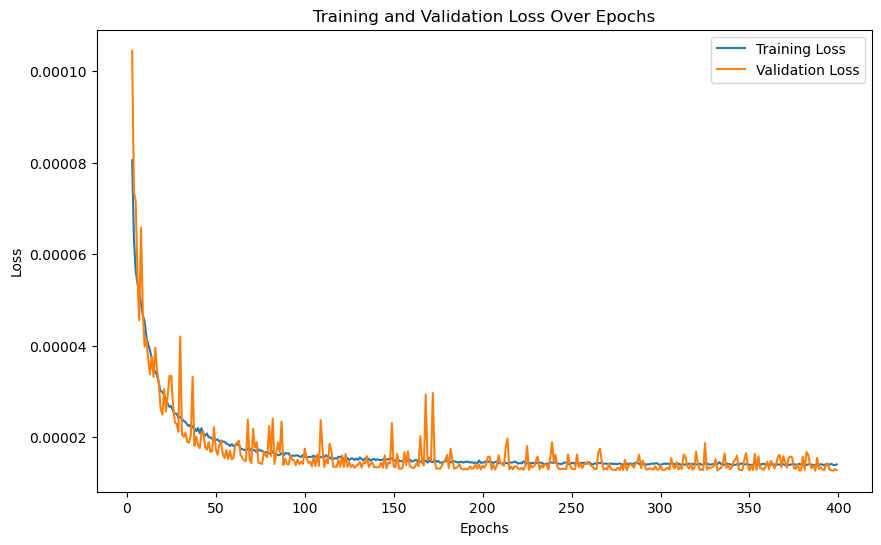

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 180.6865, Test MAE: 158.1882
Train MAPE: 0.7836, Test MAPE: 0.3697
Train DA: 0.4732, Test DA: 0.4720
Training Time: 211.3142 seconds, Evaluation Time: 0.1626 seconds



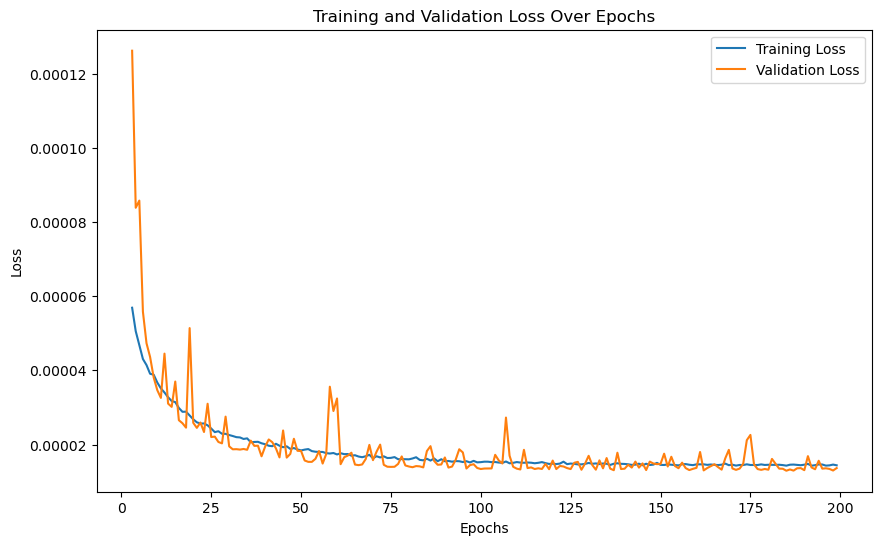

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 150.2225, Test MAE: 151.9787
Train MAPE: 0.5119, Test MAPE: 0.3453
Train DA: 0.4702, Test DA: 0.4689
Training Time: 422.2434 seconds, Evaluation Time: 0.1613 seconds



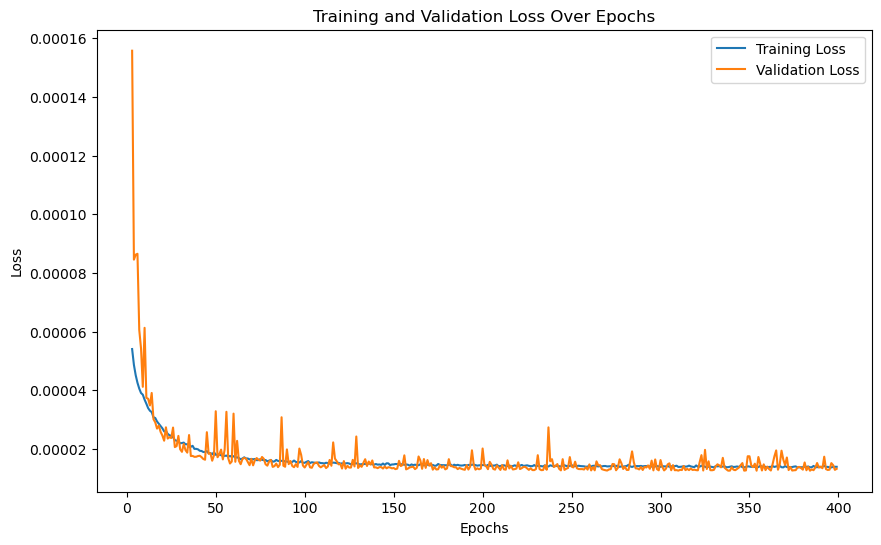

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 183.5545, Test MAE: 220.5208
Train MAPE: 0.6562, Test MAPE: 0.5188
Train DA: 0.4747, Test DA: 0.4704
Training Time: 210.3851 seconds, Evaluation Time: 0.1695 seconds



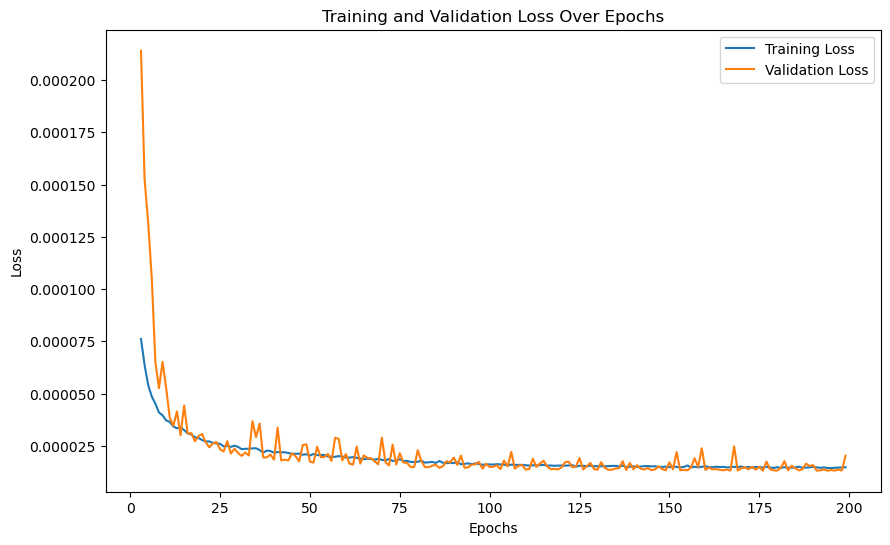

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 146.2919, Test MAE: 146.8691
Train MAPE: 0.5295, Test MAPE: 0.3199
Train DA: 0.4700, Test DA: 0.4714
Training Time: 425.0633 seconds, Evaluation Time: 0.1203 seconds



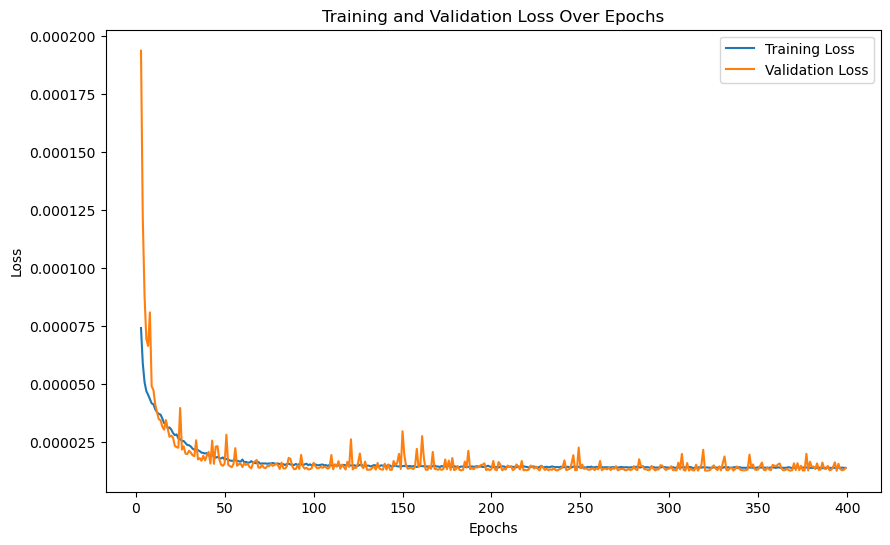

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 159.8491, Test MAE: 148.9771
Train MAPE: 0.6276, Test MAPE: 0.3347
Train DA: 0.4714, Test DA: 0.4700
Training Time: 213.7158 seconds, Evaluation Time: 0.1631 seconds



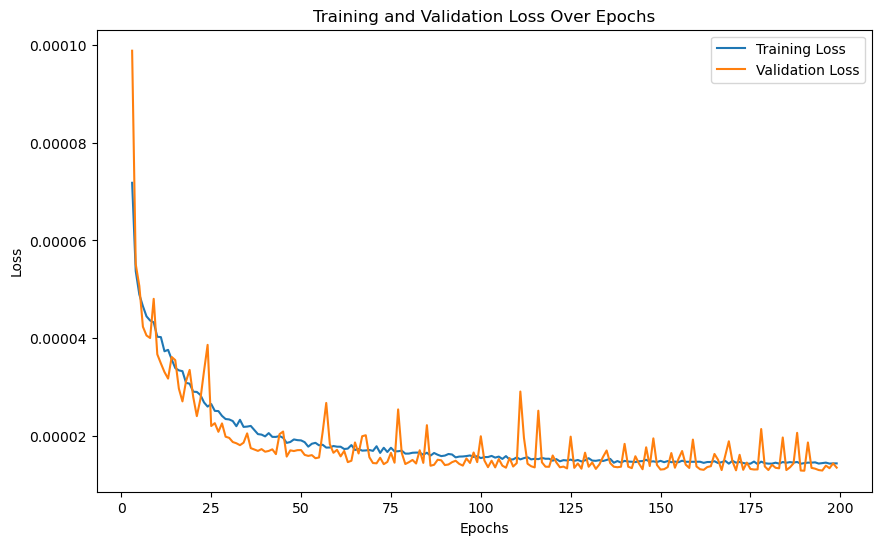

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 147.7938, Test MAE: 165.8386
Train MAPE: 0.4887, Test MAPE: 0.3656
Train DA: 0.4683, Test DA: 0.4692
Training Time: 422.4127 seconds, Evaluation Time: 0.0748 seconds



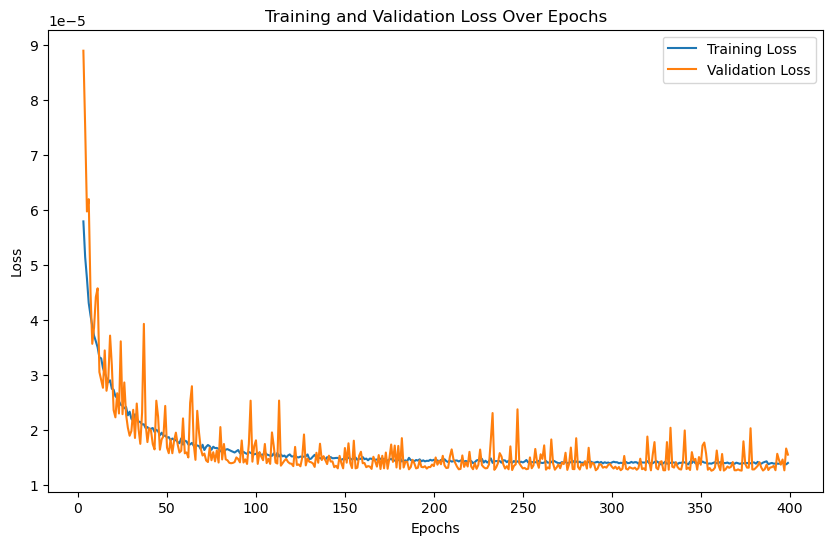

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 163.4854, Test MAE: 155.7659
Train MAPE: 0.6387, Test MAPE: 0.3587
Train DA: 0.4739, Test DA: 0.4714
Training Time: 210.8558 seconds, Evaluation Time: 0.0718 seconds



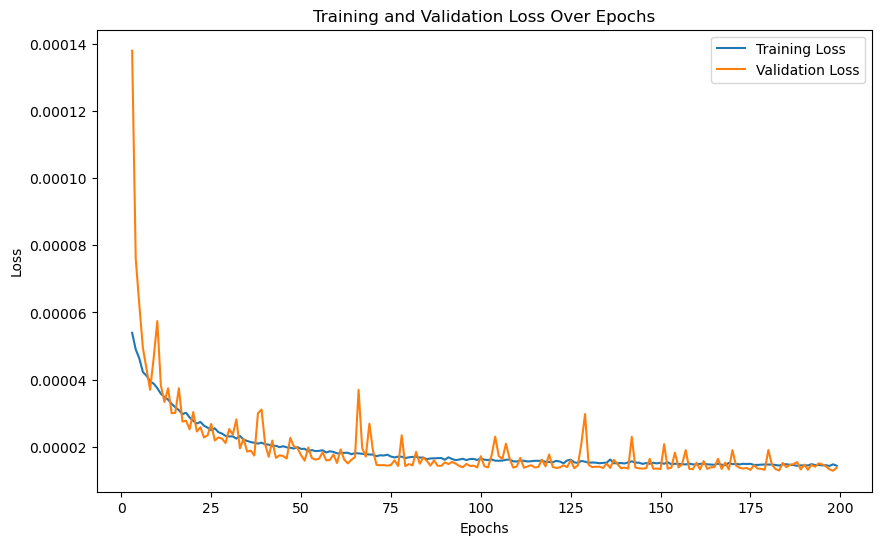

Running model with parameters: {'window_size': 24, 'lstm_dim': 50, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 152.1494, Test MAE: 149.3504
Train MAPE: 0.5700, Test MAPE: 0.3385
Train DA: 0.4698, Test DA: 0.4707
Training Time: 426.4073 seconds, Evaluation Time: 0.1609 seconds



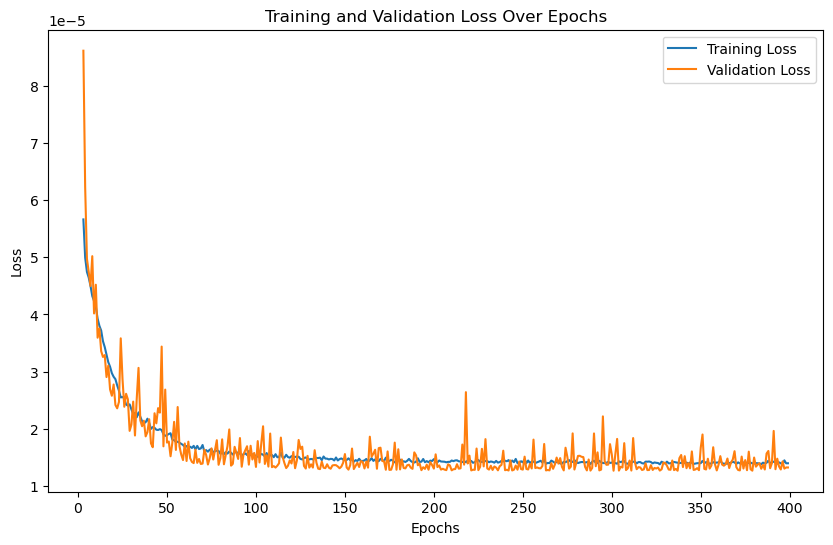

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 155.8084, Test MAE: 143.6646
Train MAPE: 0.6178, Test MAPE: 0.3155
Train DA: 0.4705, Test DA: 0.4720
Training Time: 215.7006 seconds, Evaluation Time: 0.1545 seconds



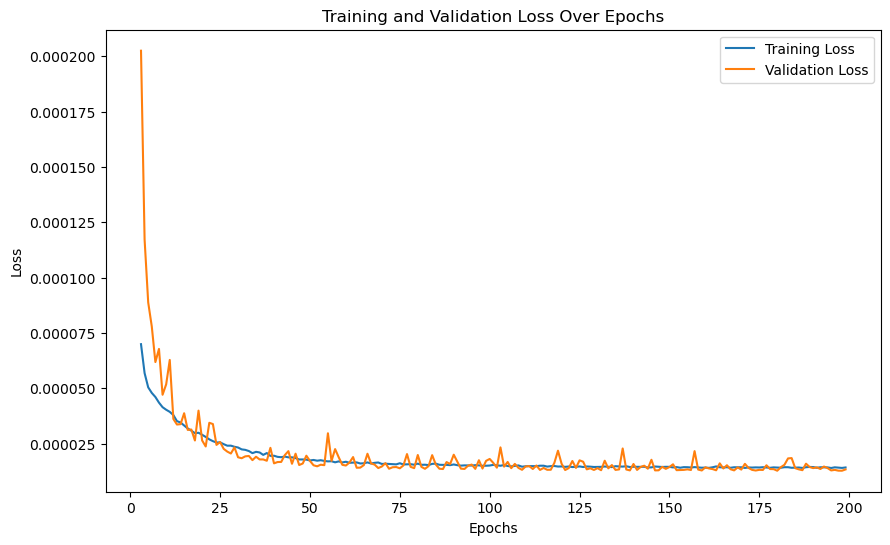

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 146.7299, Test MAE: 148.6056
Train MAPE: 0.4958, Test MAPE: 0.3358
Train DA: 0.4698, Test DA: 0.4712
Training Time: 421.9170 seconds, Evaluation Time: 0.1825 seconds



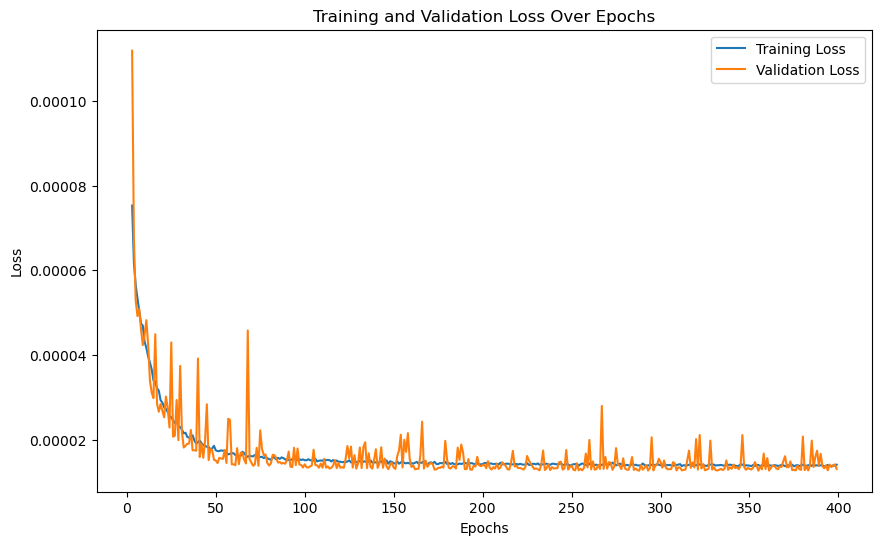

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 142.2269, Test MAE: 147.7863
Train MAPE: 0.4763, Test MAPE: 0.3291
Train DA: 0.4707, Test DA: 0.4717
Training Time: 209.8644 seconds, Evaluation Time: 0.2460 seconds



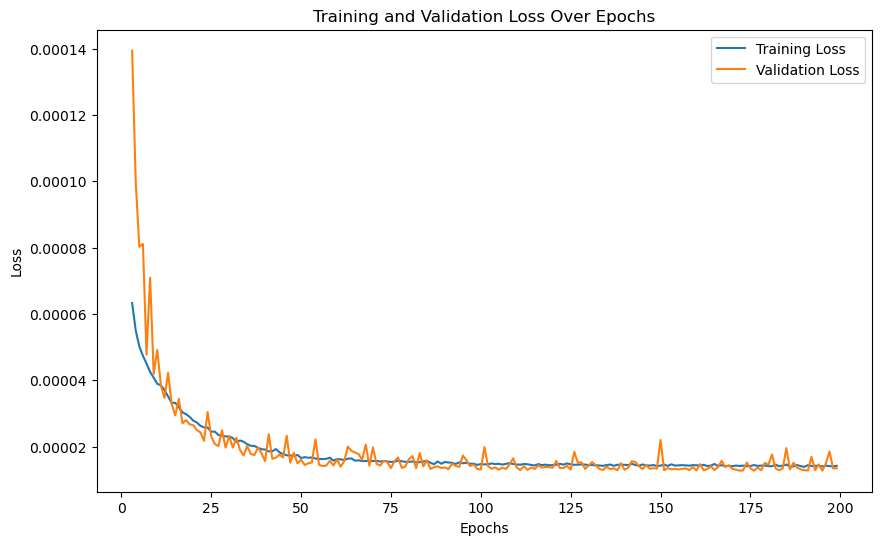

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 187.3468, Test MAE: 222.4863
Train MAPE: 0.7025, Test MAPE: 0.5250
Train DA: 0.4705, Test DA: 0.4710
Training Time: 469.6651 seconds, Evaluation Time: 0.1187 seconds



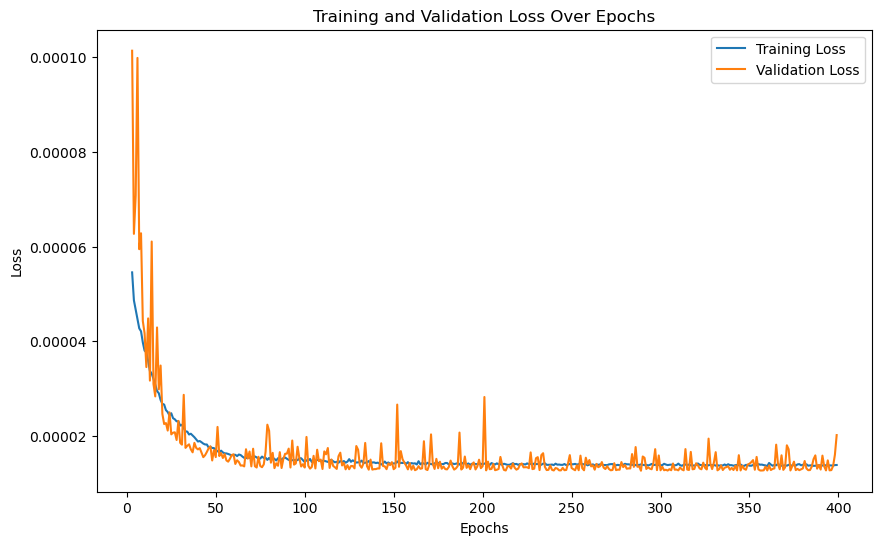

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 143.7850, Test MAE: 152.6580
Train MAPE: 0.4867, Test MAPE: 0.3418
Train DA: 0.4711, Test DA: 0.4707
Training Time: 239.5394 seconds, Evaluation Time: 0.1147 seconds



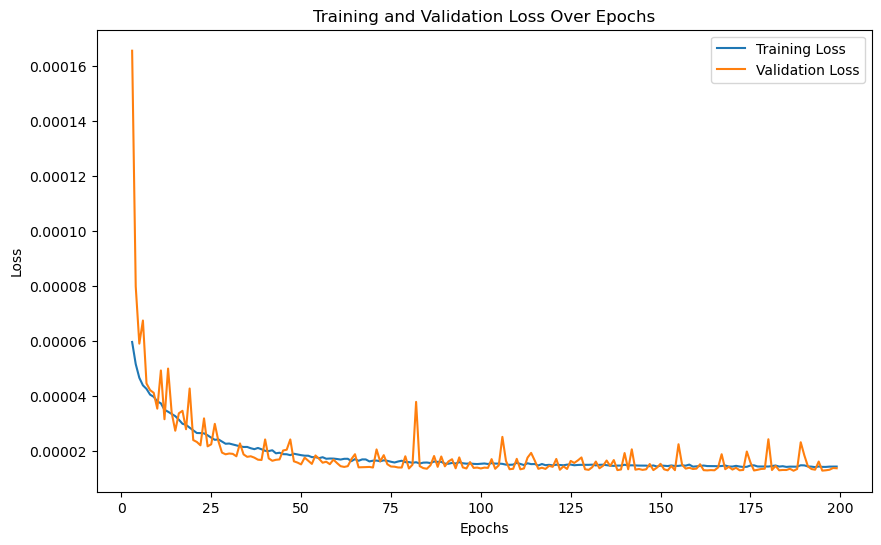

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 145.1015, Test MAE: 138.9261
Train MAPE: 0.5038, Test MAPE: 0.3064
Train DA: 0.4708, Test DA: 0.4697
Training Time: 478.8257 seconds, Evaluation Time: 0.1319 seconds



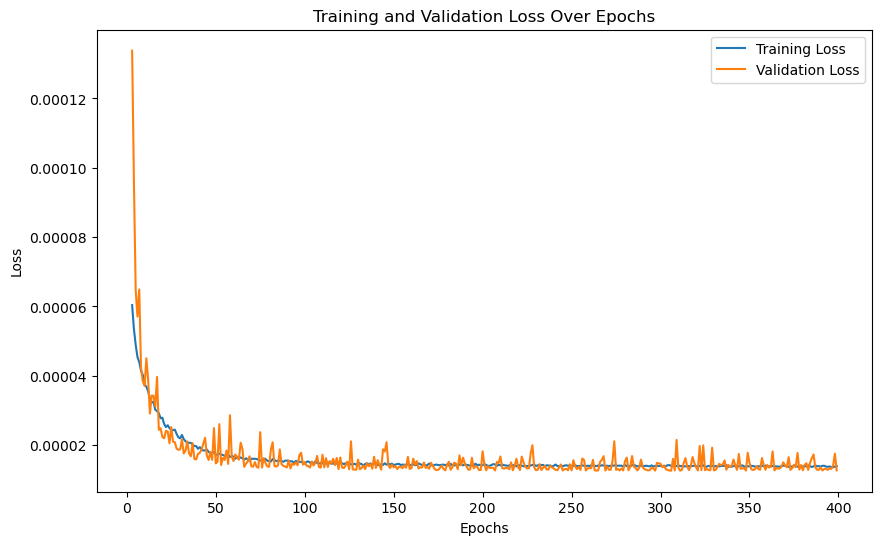

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 144.2062, Test MAE: 140.3062
Train MAPE: 0.5028, Test MAPE: 0.3111
Train DA: 0.4706, Test DA: 0.4730
Training Time: 231.6555 seconds, Evaluation Time: 0.1128 seconds



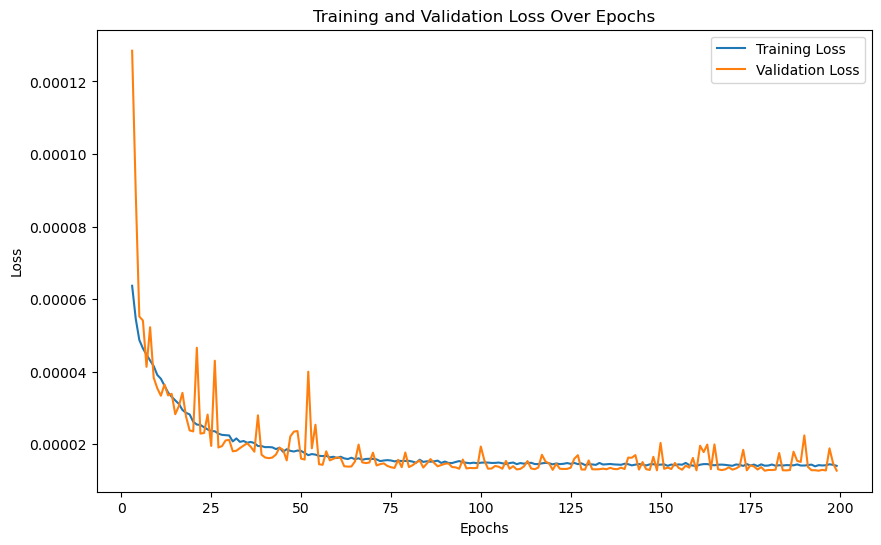

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 143.6113, Test MAE: 139.4735
Train MAPE: 0.4979, Test MAPE: 0.3074
Train DA: 0.4683, Test DA: 0.4689
Training Time: 452.9316 seconds, Evaluation Time: 0.1118 seconds



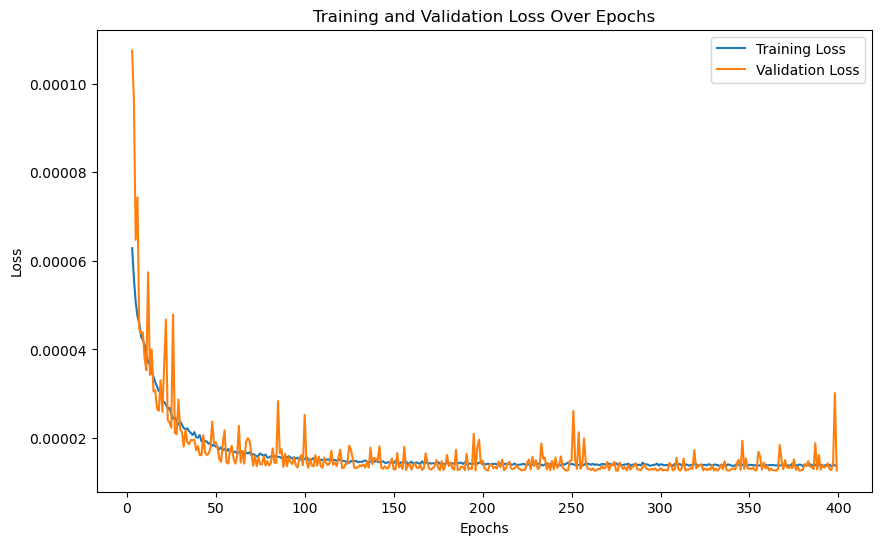

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 224.8307, Test MAE: 229.0632
Train MAPE: 1.0212, Test MAPE: 0.5669
Train DA: 0.4700, Test DA: 0.4729
Training Time: 222.6336 seconds, Evaluation Time: 0.1093 seconds



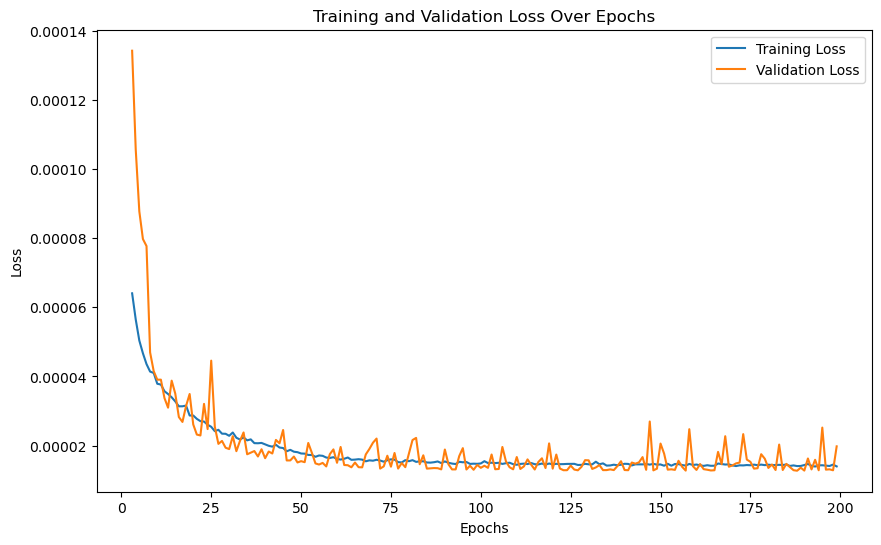

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.5640, Test MAE: 139.5175
Train MAPE: 0.4730, Test MAPE: 0.3074
Train DA: 0.4700, Test DA: 0.4705
Training Time: 441.2681 seconds, Evaluation Time: 0.1146 seconds



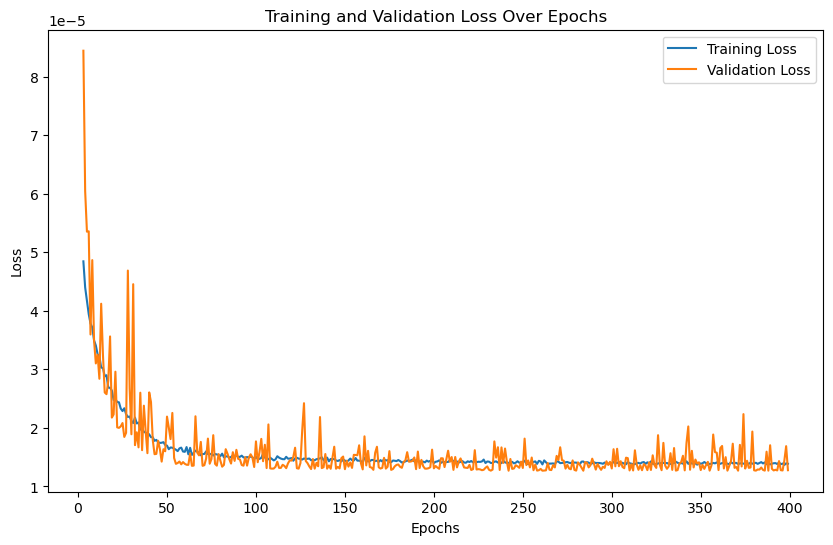

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.2562, Test MAE: 141.2959
Train MAPE: 0.4749, Test MAPE: 0.3086
Train DA: 0.4716, Test DA: 0.4720
Training Time: 226.4706 seconds, Evaluation Time: 0.1178 seconds



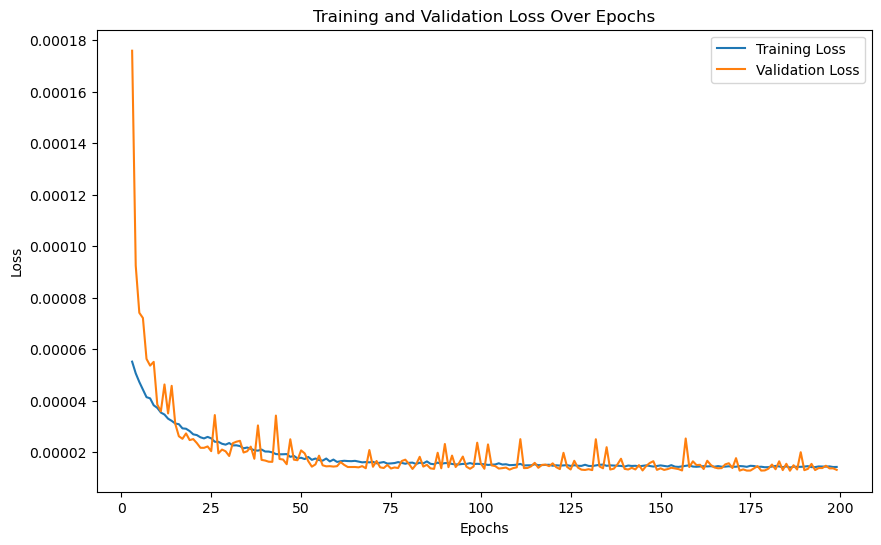

Running model with parameters: {'window_size': 24, 'lstm_dim': 75, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 140.2921, Test MAE: 142.4408
Train MAPE: 0.4659, Test MAPE: 0.3126
Train DA: 0.4708, Test DA: 0.4724
Training Time: 454.1572 seconds, Evaluation Time: 0.1141 seconds



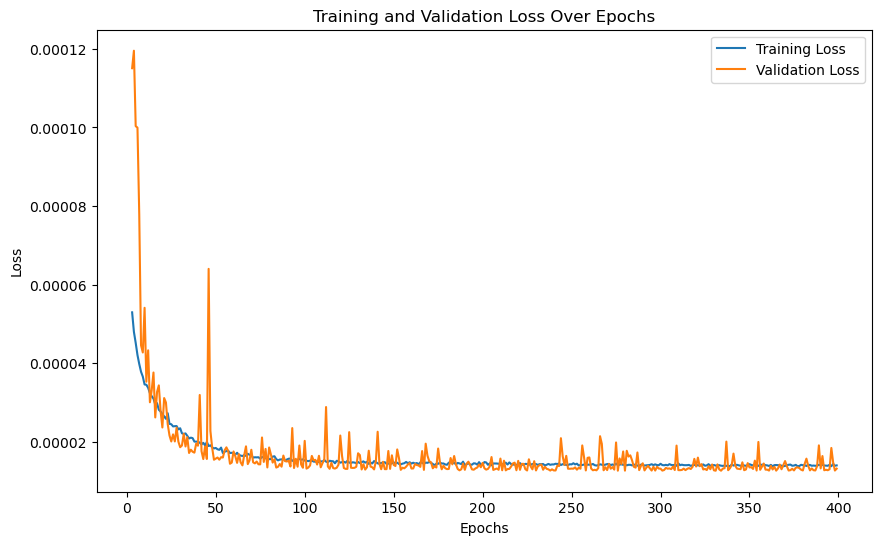

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 140.3569, Test MAE: 139.0438
Train MAPE: 0.4673, Test MAPE: 0.3058
Train DA: 0.4692, Test DA: 0.4718
Training Time: 217.0139 seconds, Evaluation Time: 0.1534 seconds



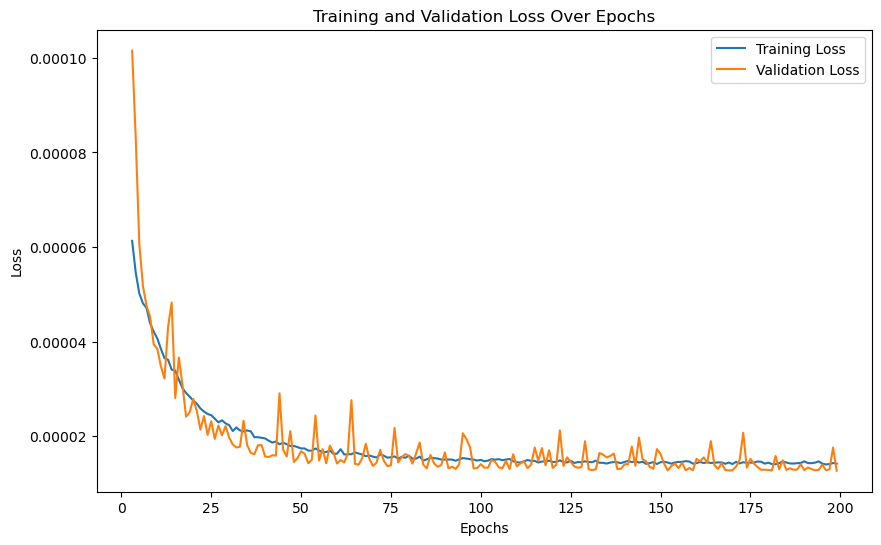

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 150.3485, Test MAE: 145.6232
Train MAPE: 0.5442, Test MAPE: 0.3232
Train DA: 0.4711, Test DA: 0.4696
Training Time: 430.3944 seconds, Evaluation Time: 0.1484 seconds



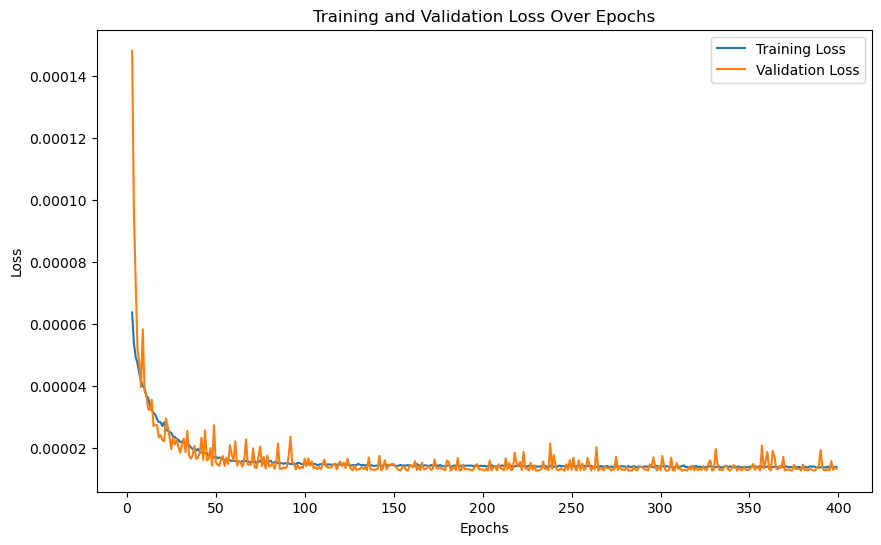

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.5414, Test MAE: 141.1986
Train MAPE: 0.4803, Test MAPE: 0.3086
Train DA: 0.4709, Test DA: 0.4708
Training Time: 211.1477 seconds, Evaluation Time: 0.1555 seconds



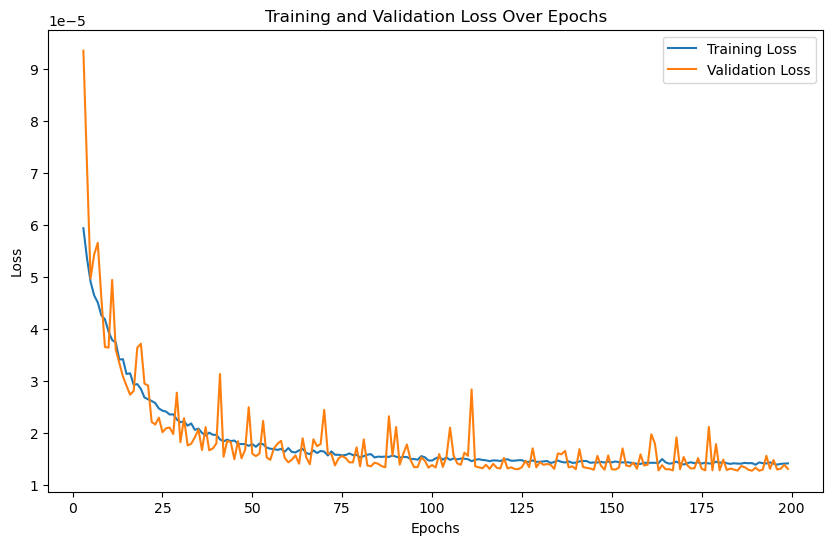

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 50, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 187.0082, Test MAE: 213.1469
Train MAPE: 0.6640, Test MAPE: 0.5090
Train DA: 0.4700, Test DA: 0.4699
Training Time: 421.8915 seconds, Evaluation Time: 0.1515 seconds



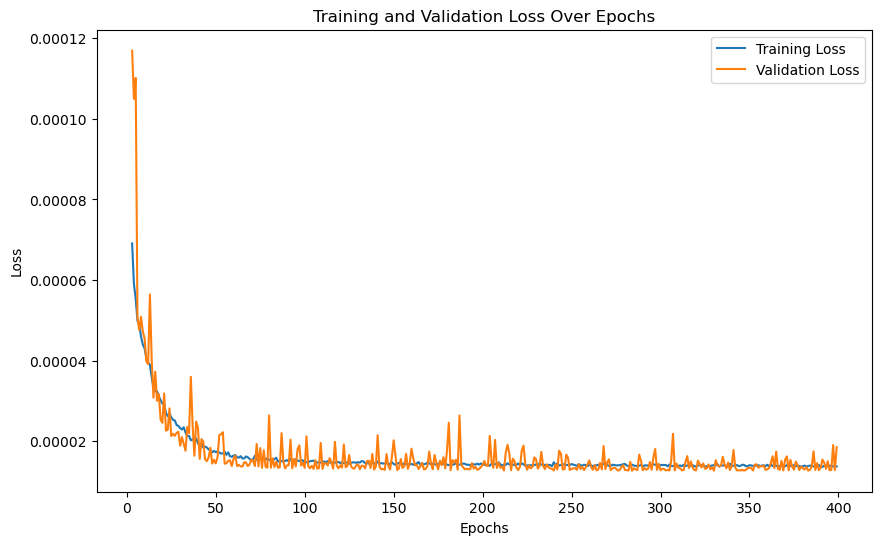

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.1484, Test MAE: 142.2600
Train MAPE: 0.4771, Test MAPE: 0.3148
Train DA: 0.4705, Test DA: 0.4726
Training Time: 210.0794 seconds, Evaluation Time: 0.1534 seconds



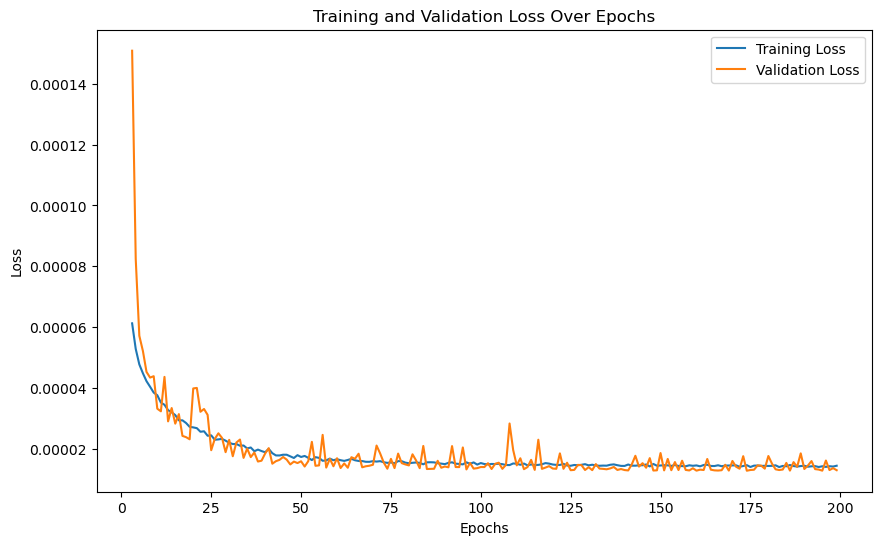

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 172.9707, Test MAE: 174.6060
Train MAPE: 0.6583, Test MAPE: 0.4161
Train DA: 0.4702, Test DA: 0.4697
Training Time: 420.6205 seconds, Evaluation Time: 0.1629 seconds



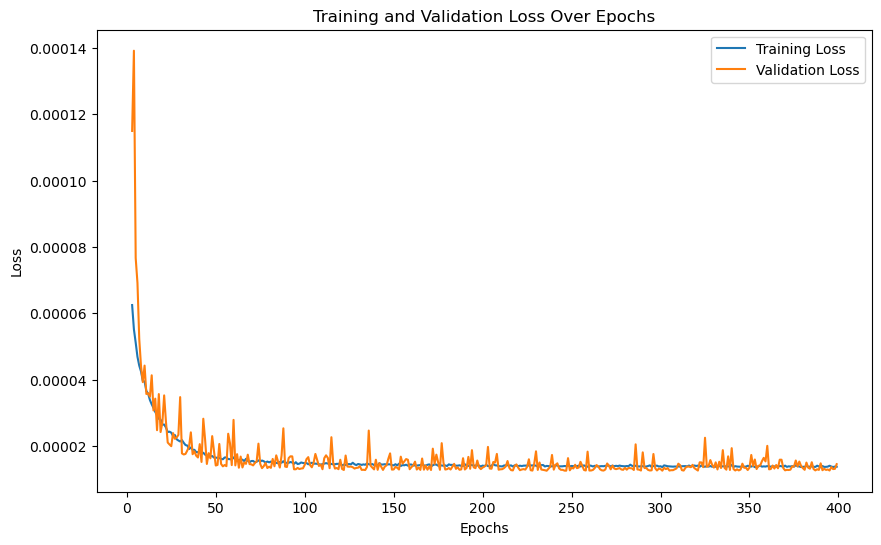

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 154.2030, Test MAE: 153.7259
Train MAPE: 0.5534, Test MAPE: 0.3506
Train DA: 0.4699, Test DA: 0.4701
Training Time: 263.4267 seconds, Evaluation Time: 0.1582 seconds



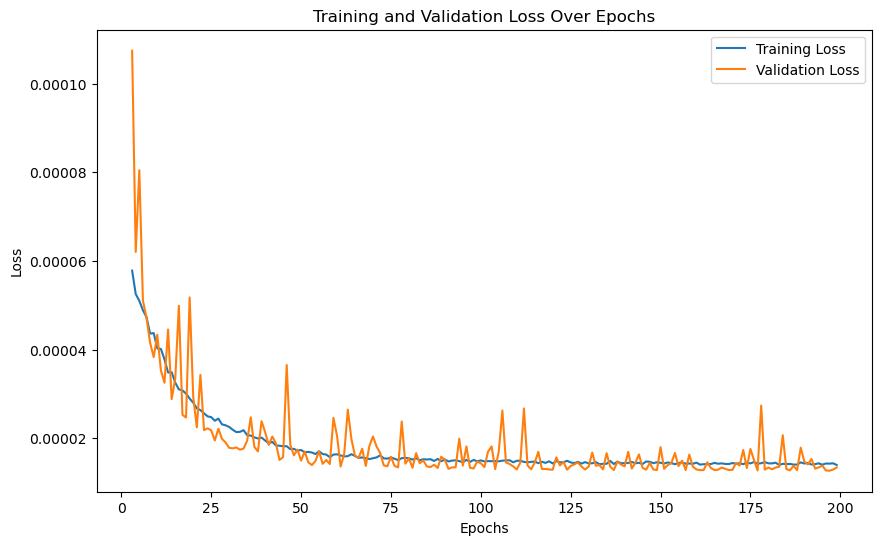

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 75, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 140.1351, Test MAE: 142.2497
Train MAPE: 0.4661, Test MAPE: 0.3105
Train DA: 0.4698, Test DA: 0.4697
Training Time: 417.9446 seconds, Evaluation Time: 0.1757 seconds



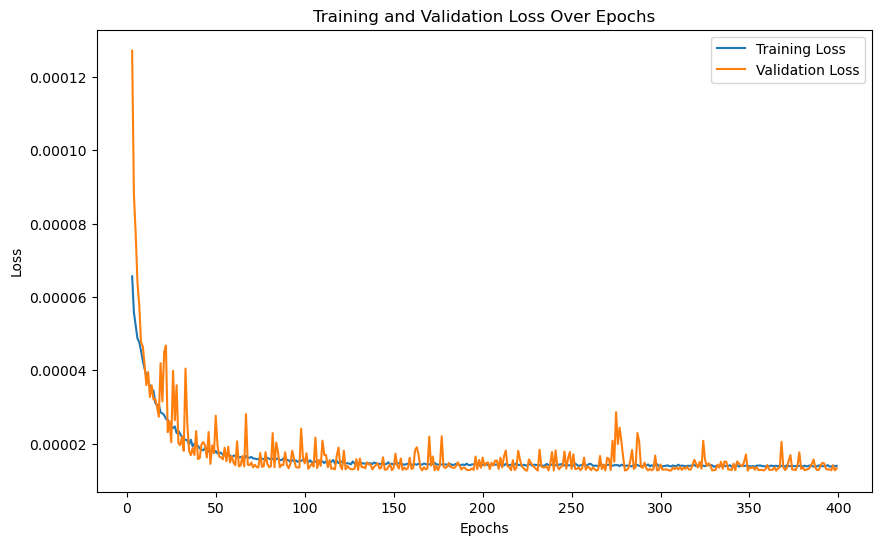

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 160.4507, Test MAE: 158.9686
Train MAPE: 0.5861, Test MAPE: 0.3637
Train DA: 0.4686, Test DA: 0.4697
Training Time: 205.1513 seconds, Evaluation Time: 0.1677 seconds



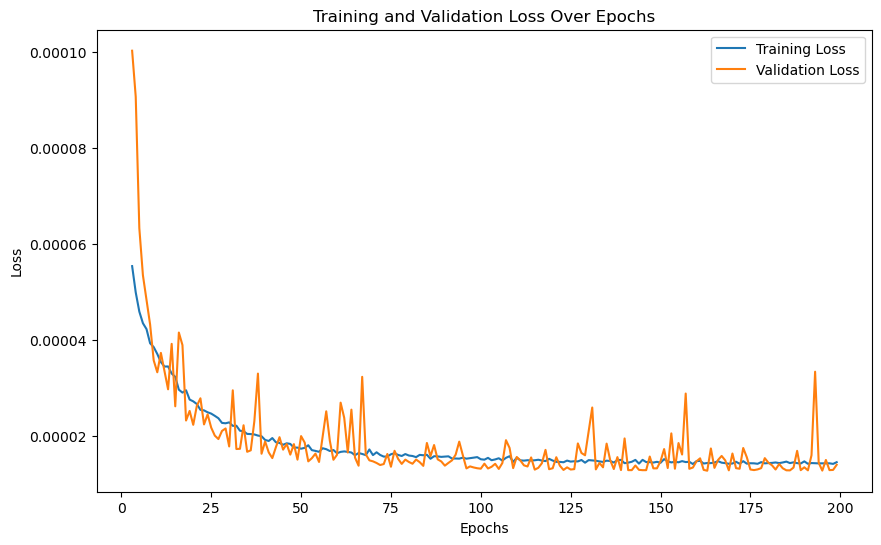

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.7288, Test MAE: 139.9418
Train MAPE: 0.4792, Test MAPE: 0.3090
Train DA: 0.4713, Test DA: 0.4696
Training Time: 404.4246 seconds, Evaluation Time: 0.1507 seconds



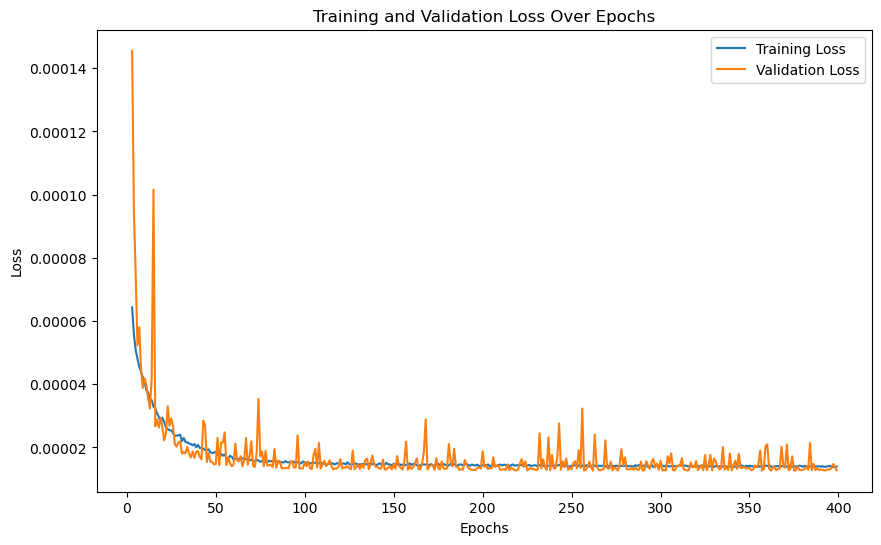

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.9359, Test MAE: 142.2593
Train MAPE: 0.4766, Test MAPE: 0.3153
Train DA: 0.4700, Test DA: 0.4717
Training Time: 197.5284 seconds, Evaluation Time: 0.1692 seconds



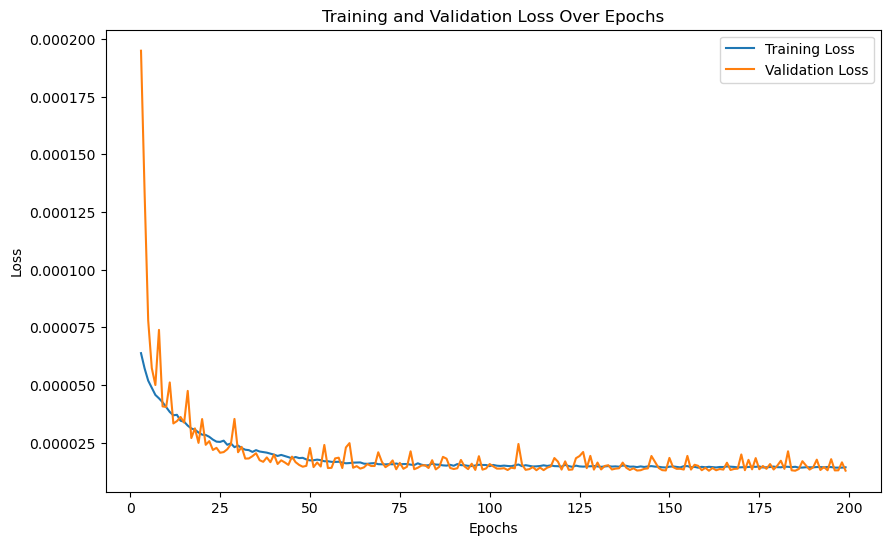

Running model with parameters: {'window_size': 24, 'lstm_dim': 100, 'dense_dim': 100, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.0001, 'num_epochs': 400, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results:

Results: Train MAE: 141.3006, Test MAE: 137.7988
Train MAPE: 0.4803, Test MAPE: 0.3031
Train DA: 0.4711, Test DA: 0.4697
Training Time: 421.9777 seconds, Evaluation Time: 0.1505 seconds



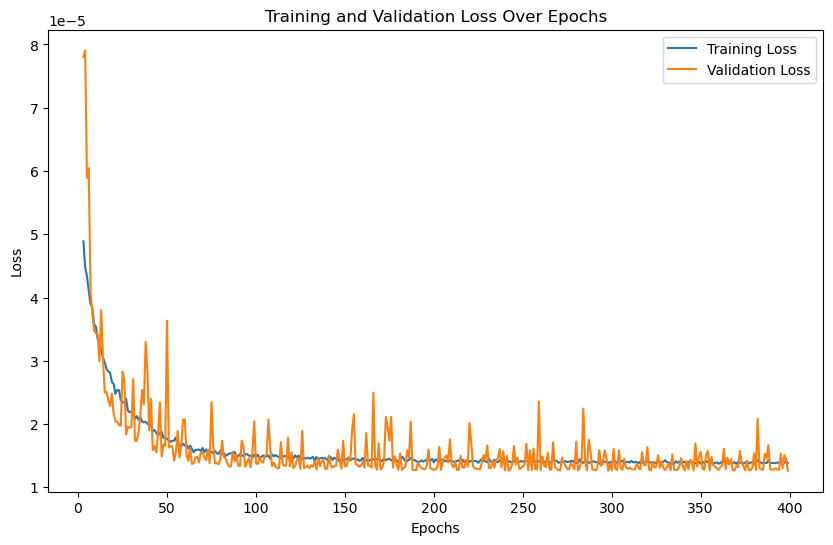

Total time taken: 11707.63280081749 seconds


Press Enter to stop the beep sound... 


Beep sound stopped.


In [32]:
# Define parameter space
parameter_space = {
    'window_size': [24],
    'lstm_dim': [50, 75, 100],
    'dense_dim': [50, 75, 100],
    'num_layers': [1],
    'dropout': [0.1, 0.2],
    'lr': [0.0001],
    'num_epochs': [200, 400],
    'batch_size': [64],
    'optimizer_type': ['Adam'],
    'patience': [24],
    'activation_function': [nn.Tanh]
}

# Start total timer
start = time.time()

# Grid search
for params in itertools.product(*parameter_space.values()):
    param_dict = dict(zip(parameter_space.keys(), params))
    print(f"Running model with parameters: {param_dict}\n")
    # Run with fixed epochs
    print('Results:\n')
    train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete14', use_early_stopping=False, plot_loss=True)


# Calculate total time
end = time.time()
total_time = end - start

# Print the total time taken
print(f"Total time taken: {total_time} seconds")

# Function to play a beep sound in a loop
def play_beep():
    while not stop_beep_flag:
        winsound.Beep(2000, 600)
        time.sleep(0.7)
        
# Start the beep sound
stop_beep_flag = False
beep_thread = Thread(target=play_beep)
beep_thread.start()

input("Press Enter to stop the beep sound...")
stop_beep_flag = True
beep_thread.join()
print("Beep sound stopped.")

In [36]:
def calculate_metrics(y_true, y_pred):
    # Ensure y_true and y_pred are numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Convert to percentage
    
    # Calculate Directional Accuracy
    true_directions = np.sign(y_true[1:] - y_true[:-1])
    pred_directions = np.sign(y_pred[1:] - y_pred[:-1])
    da = np.mean(true_directions == pred_directions) * 100  # Convert to percentage
    
    return mape, da

In [37]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, lstm_dim, dense_dim1, dense_dim2, output_dim, num_layers=1, dropout=0.0):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, lstm_dim, num_layers=num_layers, batch_first=True, dropout=(dropout if num_layers > 1 else 0))
        self.fc1 = nn.Linear(lstm_dim, dense_dim1)
        self.fc2 = nn.Linear(dense_dim1, dense_dim2)
        self.fc3 = nn.Linear(dense_dim2, output_dim)
        self.activation = nn.Tanh()

    def forward(self, x):
        x, _ = self.lstm(x)
        x = x[:, -1, :]  # Use the output of the last time step
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x


In [38]:
def train_and_evaluate(df, target_column, feature_columns, params, file_prefix='results', use_early_stopping=True, plot_loss=False):
    result = {}  # Initialize result to ensure it's always defined
    try:
        # Extract parameters
        window_size = params['window_size']
        lstm_dim = params['lstm_dim']
        dense_dim1 = params['dense_dim1']
        dense_dim2 = params['dense_dim2']
        num_layers = params['num_layers']
        dropout = params['dropout']
        lr = params['lr']
        batch_size = params['batch_size']
        num_epochs = params['num_epochs']
        optimizer_type = params['optimizer_type']
        patience = params['patience']

        # Clear CUDA cache
        torch.cuda.empty_cache()

        # Prepare data
        X_train_seq, X_test_seq, y_train_seq, y_test_seq, scaler_y = prepare_data(df, target_column, window_size, feature_columns)

        # Convert to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
        X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
        y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1).to(device)
        y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).view(-1, 1).to(device)

        # Create data loaders
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
        train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

        # Model parameters
        input_dim = X_train_tensor.shape[2]
        output_dim = 1

        model = LSTMModel(input_dim, lstm_dim, dense_dim1, dense_dim2, output_dim, num_layers, dropout).to(device)

        # Define loss and optimizer
        criterion = nn.MSELoss()
        optimizer = getattr(optim, optimizer_type)(model.parameters(), lr=lr)

        # Training loop
        best_loss = float('inf')
        patience_counter = 0
        start_time = time.time()

        training_losses = []
        validation_losses = []

        for epoch in range(num_epochs):
            model.train()
            epoch_train_loss = 0
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_train_loss += loss.item()

            epoch_train_loss /= len(train_loader)
            training_losses.append(epoch_train_loss)

            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, labels in test_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()

            val_loss /= len(test_loader)
            validation_losses.append(val_loss)

            # if use_early_stopping:
            #     if val_loss < best_loss:
            #         best_loss = val_loss
            #         patience_counter = 0
            #         torch.save(model.state_dict(), f'{file_prefix}_{target_column}_best_model.pth')
            #     else:
            #         patience_counter += 1
            #         if patience_counter >= patience:
            #             break

        training_time = time.time() - start_time

        # # Save the final model if early stopping was not used or not triggered
        # if not use_early_stopping or patience_counter < patience:
        #     torch.save(model.state_dict(), f'{file_prefix}_{target_column}_final_model.pth')

        # Evaluate the model
        model.eval()
        evaluation_start_time = time.time()
        with torch.no_grad():
            train_predictions = model(X_train_tensor).cpu().numpy()
            test_predictions = model(X_test_tensor).cpu().numpy()

            # Inverse transform predictions and actual values
            y_train_seq = y_train_seq.reshape(-1, 1)
            y_test_seq = y_test_seq.reshape(-1, 1)
            train_predictions_inverse = scaler_y.inverse_transform(train_predictions)
            test_predictions_inverse = scaler_y.inverse_transform(test_predictions)
            y_train_inverse = scaler_y.inverse_transform(y_train_seq)
            y_test_inverse = scaler_y.inverse_transform(y_test_seq)

            train_mse = mean_squared_error(y_train_inverse, train_predictions_inverse)
            test_mse = mean_squared_error(y_test_inverse, test_predictions_inverse)
            train_mae = mean_absolute_error(y_train_inverse, train_predictions_inverse)
            test_mae = mean_absolute_error(y_test_inverse, test_predictions_inverse)
            train_rmse = np.sqrt(train_mse)
            test_rmse = np.sqrt(test_mse)
            train_r2 = r2_score(y_train_inverse, train_predictions_inverse)
            test_r2 = r2_score(y_test_inverse, test_predictions_inverse)

            train_mape, train_directional_acc = calculate_metrics(y_train_inverse, train_predictions_inverse)
            test_mape, test_directional_acc = calculate_metrics(y_test_inverse, test_predictions_inverse)

        evaluation_time = time.time() - evaluation_start_time

        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim1": dense_dim1,
            "dense_dim2": dense_dim2,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "train_mse": train_mse,
            "test_mse": test_mse,
            "train_mae": train_mae,
            "test_mae": test_mae,
            "train_rmse": train_rmse,
            "test_rmse": test_rmse,
            "train_r2": train_r2,
            "test_r2": test_r2,
            "train_mape": train_mape,
            "test_mape": test_mape,
            "train_directional_acc": train_directional_acc,
            "test_directional_acc": test_directional_acc,
            "training_time": training_time,
            "evaluation_time": evaluation_time,
            "patience": patience
        }

        # Save result to a CSV file
        with open(f'{file_prefix}_{target_column}.csv', 'a', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=result.keys())
            if f.tell() == 0:
                writer.writeheader()  # Write header only if file is empty
            writer.writerow(result)

        # Print summary of the results
        print(f"Results: Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
        print(f"Train MAPE: {train_mape:.4f}, Test MAPE: {test_mape:.4f}")
        print(f"Train DA: {train_directional_acc:.4f}, Test DA: {test_directional_acc:.4f}")
        print(f"Training Time: {training_time:.4f} seconds, Evaluation Time: {evaluation_time:.4f} seconds\n")

        # Plot loss over epochs if specified
        if plot_loss:
            plot_loss_over_epochs(training_losses, validation_losses, f'{file_prefix}_{target_column}', start_epoch=10)

    except Exception as e:
        print(f"An error occurred: {e}")
        # Ensure result is always defined, even in case of error
        result = {
            "window_size": window_size,
            "lstm_dim": lstm_dim,
            "num_layers": num_layers,
            "dense_dim1": dense_dim1,
            "dense_dim2": dense_dim2,
            "dropout": dropout,
            "lr": lr,
            "batch_size": batch_size,
            "num_epochs": num_epochs,
            "optimizer_type": optimizer_type,
            "error": str(e)
        }

    return result

In [39]:
# Define parameter space
parameter_space = {
    'window_size': [24],
    'lstm_dim': [32, 64, 128],
    'dense_dim1': [32, 64, 128],
    'dense_dim2': [32],
    'num_layers': [1],
    'dropout': [0.0, 0.05, 0.1],
    'lr': [0.0001],
    'num_epochs': [200, 300],
    'batch_size': [64],
    'optimizer_type': ['Adam'],
    'patience': [24],
    'activation_function': [nn.Tanh]  # Ensure this is handled if used
}

In [40]:
### REMOVAL OF 'OPEN' AS PER p9

# Define feature combination
features = ['high', 'low', 'close', 'volume',
       'quote_vol', 'count', 'buy_base', 'buy_quote', 'high_p', 'low_p', 'close_p']

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 147.8169, Test MAE: 154.3654
Train MAPE: 0.5098, Test MAPE: 0.3401
Train DA: 47.5190, Test DA: 47.1179
Training Time: 231.0628 seconds, Evaluation Time: 0.0708 seconds



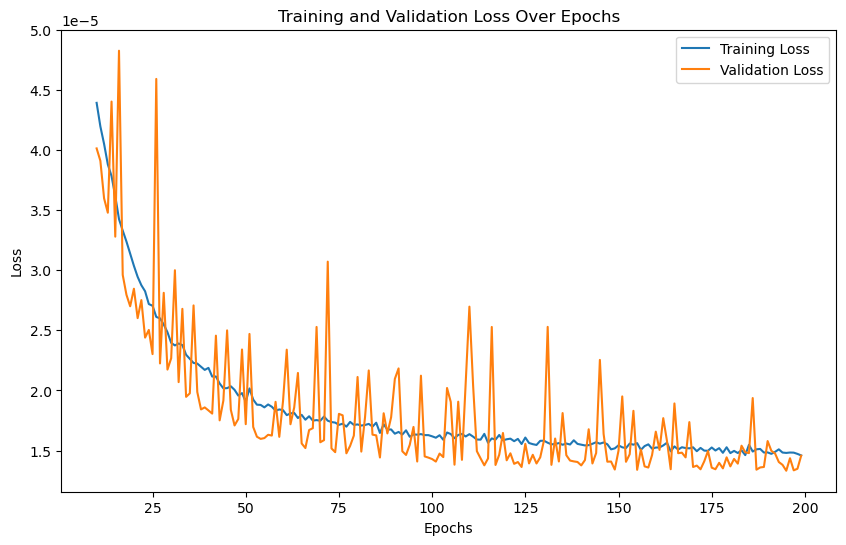

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 161.6223, Test MAE: 199.4608
Train MAPE: 0.5386, Test MAPE: 0.4468
Train DA: 47.1828, Test DA: 47.0915
Training Time: 344.7792 seconds, Evaluation Time: 0.0508 seconds



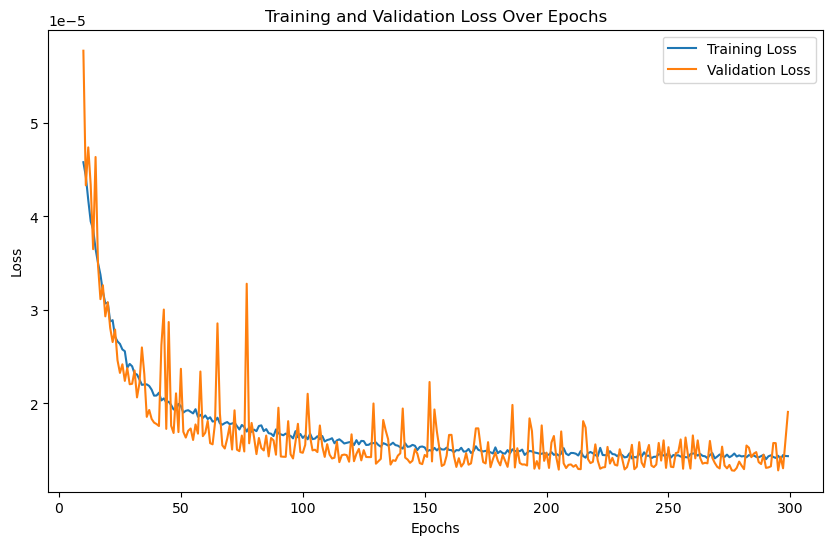

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 162.0529, Test MAE: 171.1880
Train MAPE: 0.5569, Test MAPE: 0.3975
Train DA: 47.4630, Test DA: 47.1840
Training Time: 229.4834 seconds, Evaluation Time: 0.0550 seconds



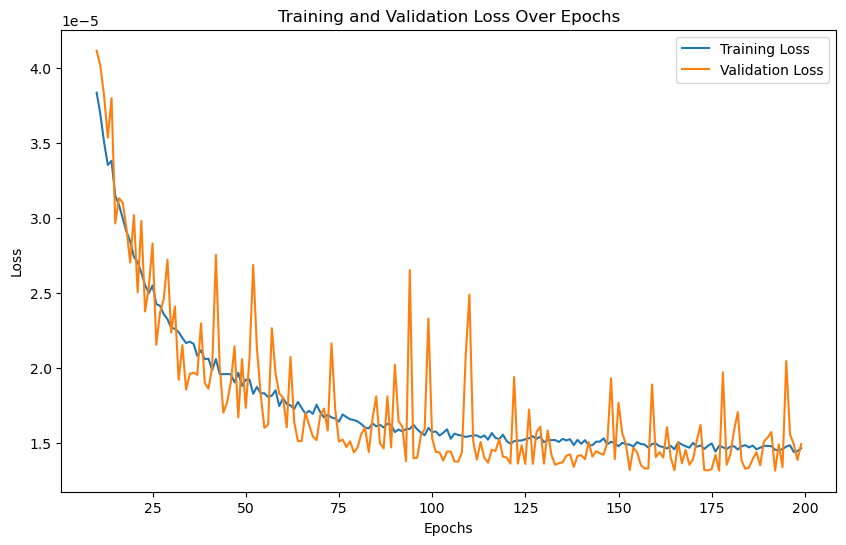

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 178.5846, Test MAE: 181.7140
Train MAPE: 0.7282, Test MAPE: 0.4372
Train DA: 47.0575, Test DA: 47.3162
Training Time: 342.3968 seconds, Evaluation Time: 0.0475 seconds



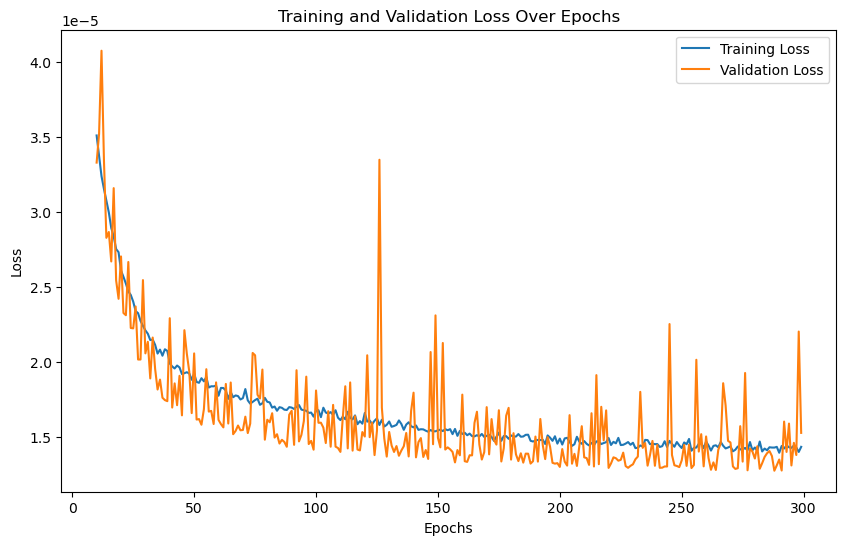

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 143.1029, Test MAE: 141.6152
Train MAPE: 0.4844, Test MAPE: 0.3129
Train DA: 47.4069, Test DA: 47.0386
Training Time: 229.1086 seconds, Evaluation Time: 0.0565 seconds



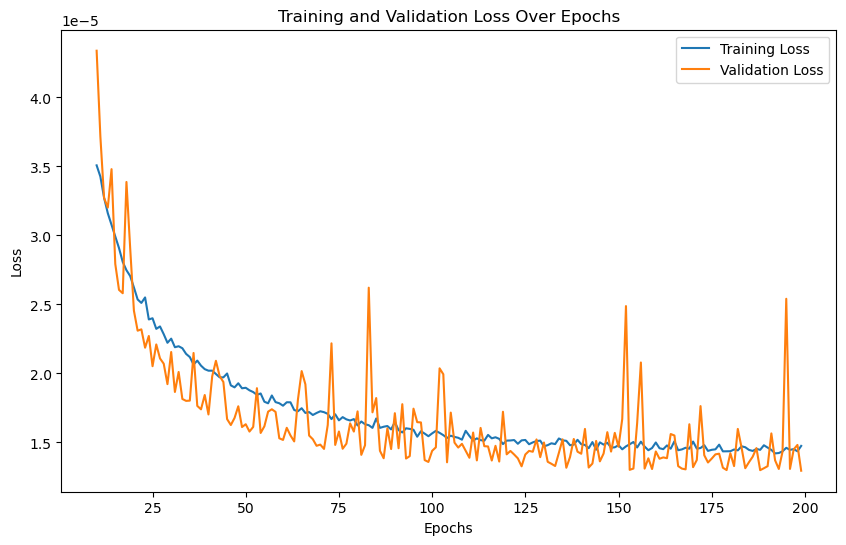

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 144.5092, Test MAE: 143.6550
Train MAPE: 0.4851, Test MAPE: 0.3177
Train DA: 47.4828, Test DA: 47.1311
Training Time: 337.6065 seconds, Evaluation Time: 0.0775 seconds



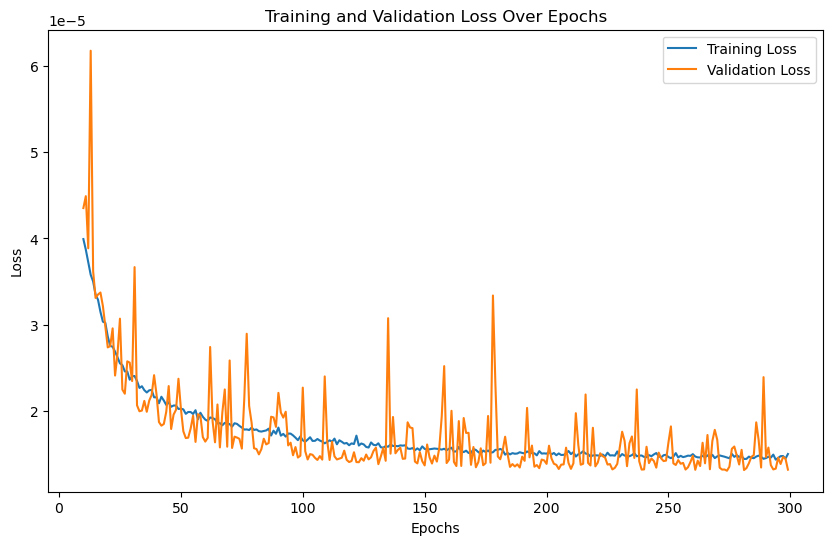

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 141.4181, Test MAE: 139.4999
Train MAPE: 0.4720, Test MAPE: 0.3074
Train DA: 47.2586, Test DA: 46.8403
Training Time: 222.0189 seconds, Evaluation Time: 0.0576 seconds



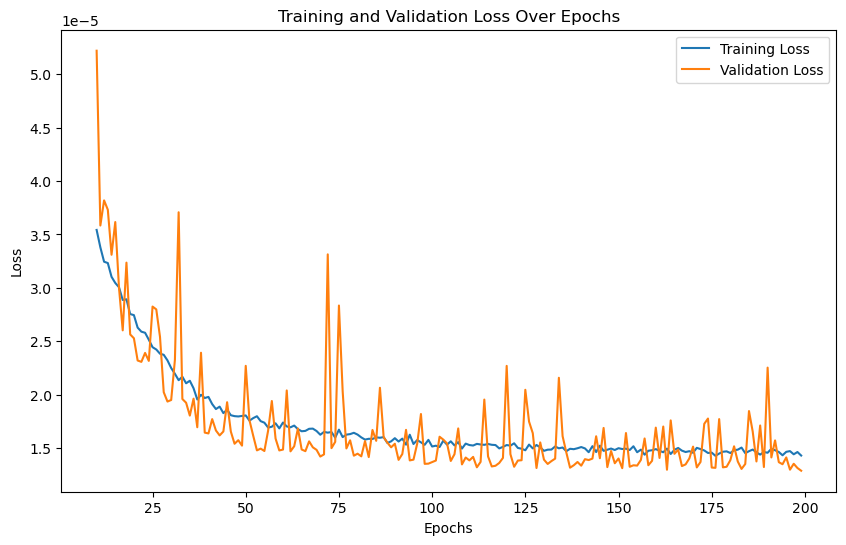

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 142.4125, Test MAE: 143.9845
Train MAPE: 0.4802, Test MAPE: 0.3203
Train DA: 47.2157, Test DA: 47.3295
Training Time: 332.6654 seconds, Evaluation Time: 0.0519 seconds



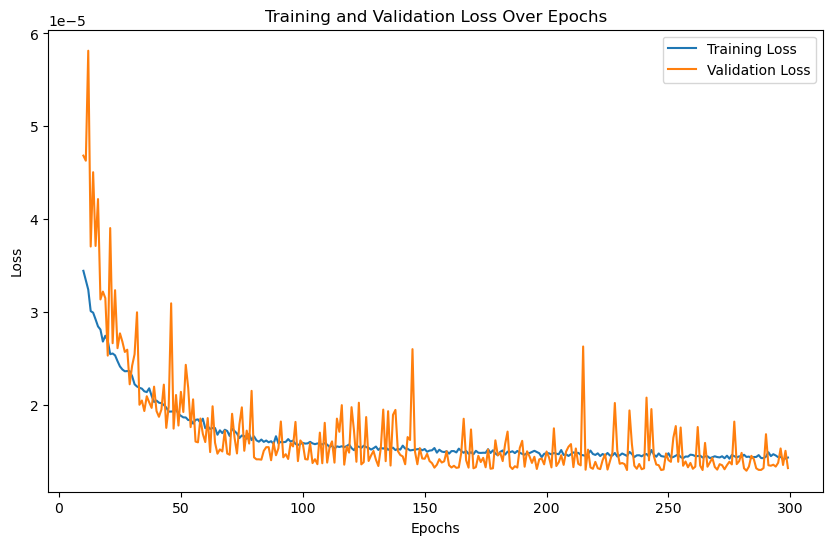

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 224.9037, Test MAE: 220.8515
Train MAPE: 1.0200, Test MAPE: 0.5578
Train DA: 47.4168, Test DA: 47.3030
Training Time: 222.2703 seconds, Evaluation Time: 0.0559 seconds



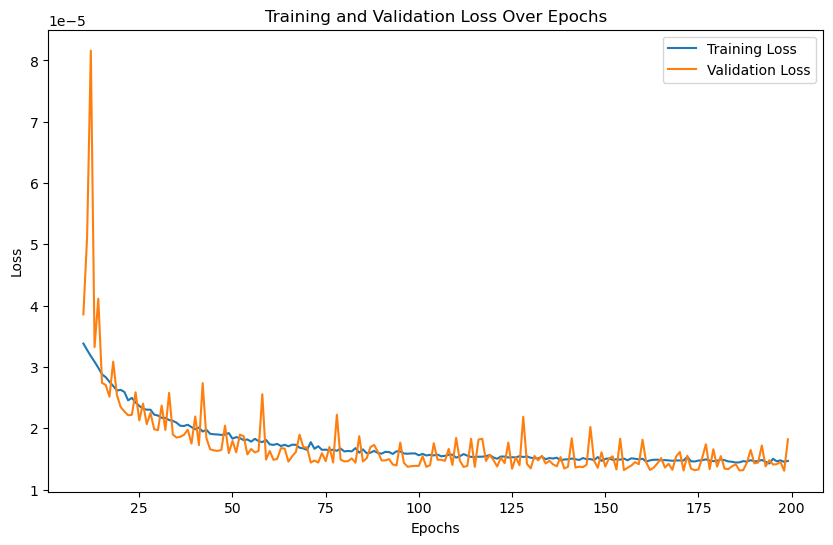

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 191.0441, Test MAE: 199.4537
Train MAPE: 0.7848, Test MAPE: 0.4689
Train DA: 47.1069, Test DA: 47.3295
Training Time: 344.4367 seconds, Evaluation Time: 0.0703 seconds



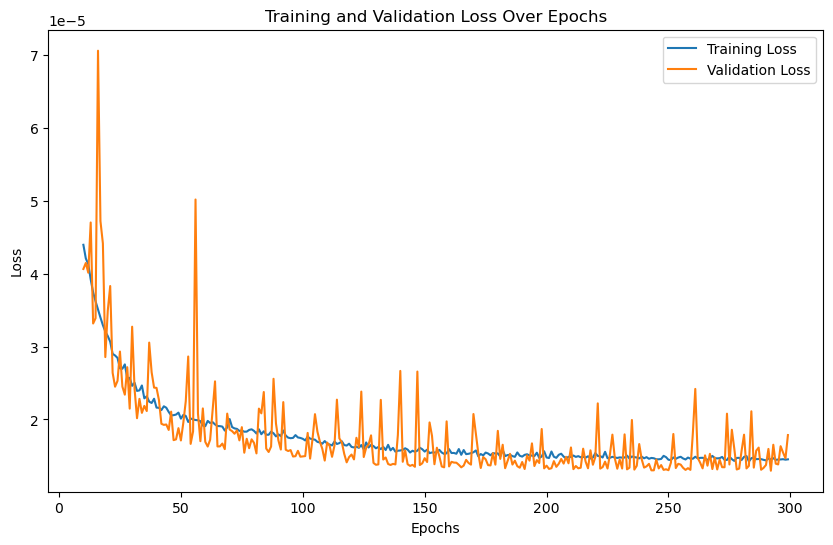

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 149.4366, Test MAE: 147.5342
Train MAPE: 0.5091, Test MAPE: 0.3283
Train DA: 47.5355, Test DA: 47.2237
Training Time: 231.0250 seconds, Evaluation Time: 0.0507 seconds



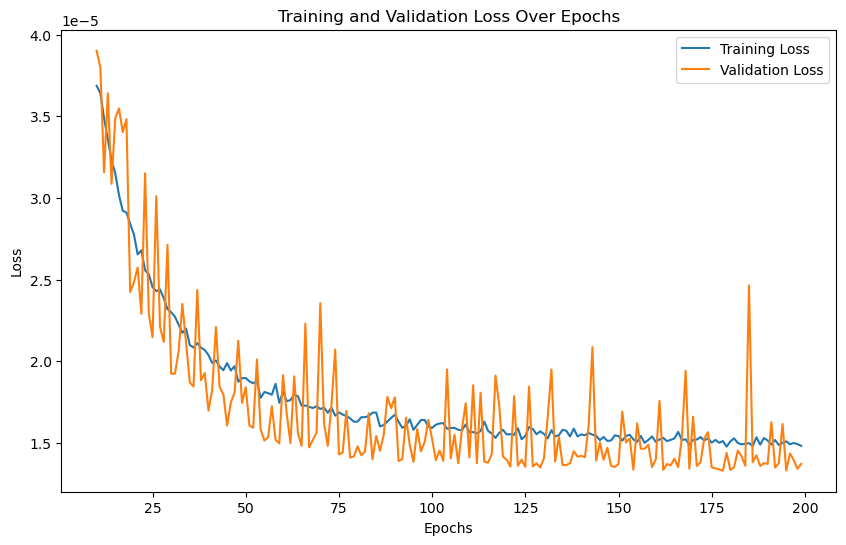

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 144.1271, Test MAE: 144.6696
Train MAPE: 0.4879, Test MAPE: 0.3160
Train DA: 47.3740, Test DA: 47.1973
Training Time: 346.5197 seconds, Evaluation Time: 0.0573 seconds



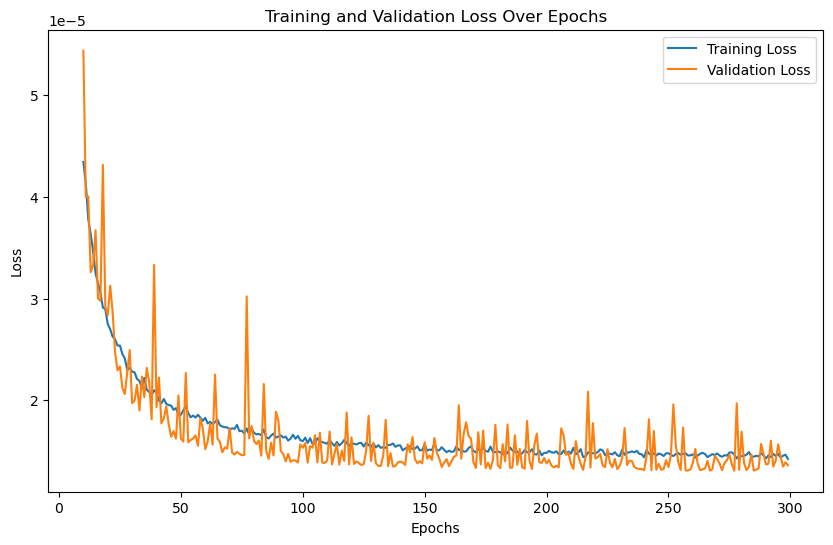

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 160.6466, Test MAE: 150.3922
Train MAPE: 0.6301, Test MAPE: 0.3443
Train DA: 47.5553, Test DA: 47.0518
Training Time: 231.1952 seconds, Evaluation Time: 0.0482 seconds



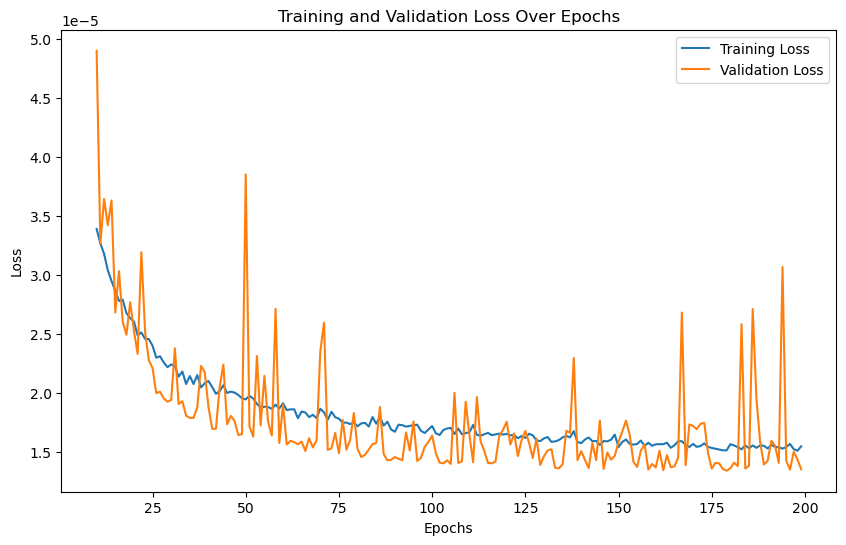

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 157.8997, Test MAE: 149.1274
Train MAPE: 0.6244, Test MAPE: 0.3214
Train DA: 47.0377, Test DA: 46.9989
Training Time: 343.5223 seconds, Evaluation Time: 0.0538 seconds



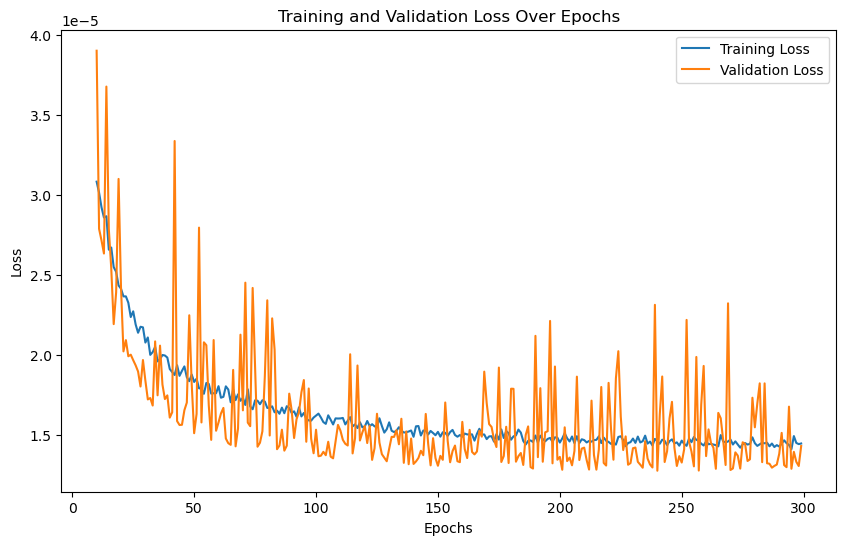

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 143.6463, Test MAE: 146.5224
Train MAPE: 0.4835, Test MAPE: 0.3170
Train DA: 47.2256, Test DA: 47.1708
Training Time: 229.4623 seconds, Evaluation Time: 0.0573 seconds



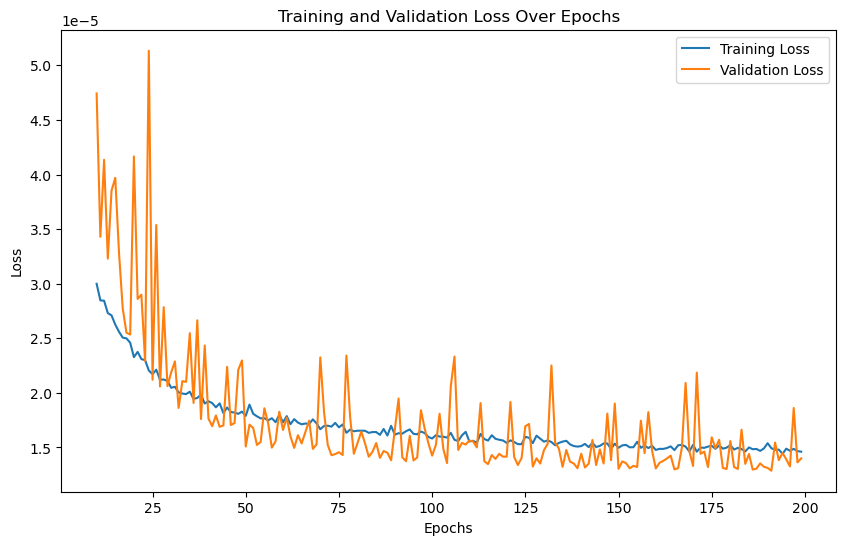

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 142.4547, Test MAE: 141.9256
Train MAPE: 0.4761, Test MAPE: 0.3133
Train DA: 47.0509, Test DA: 47.1708
Training Time: 338.1038 seconds, Evaluation Time: 0.0514 seconds



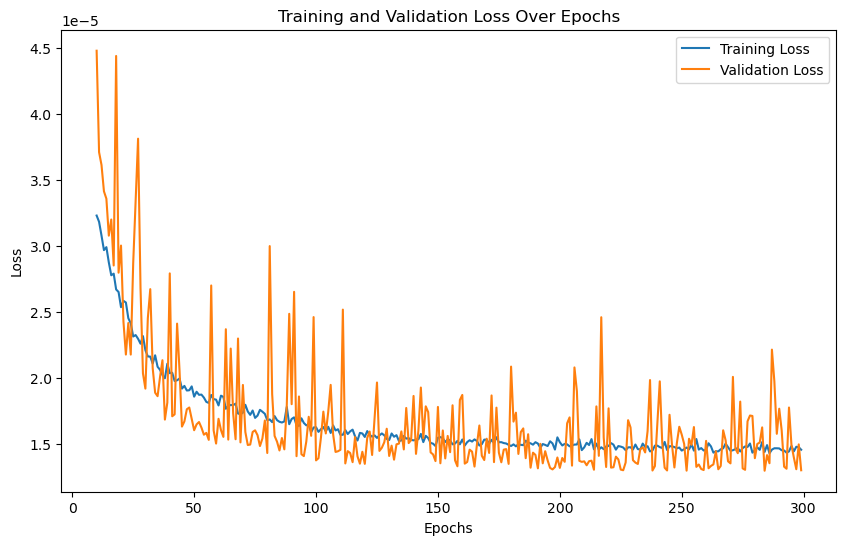

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 203.7363, Test MAE: 219.8601
Train MAPE: 0.8655, Test MAPE: 0.5305
Train DA: 47.5487, Test DA: 47.3162
Training Time: 223.0241 seconds, Evaluation Time: 0.0507 seconds



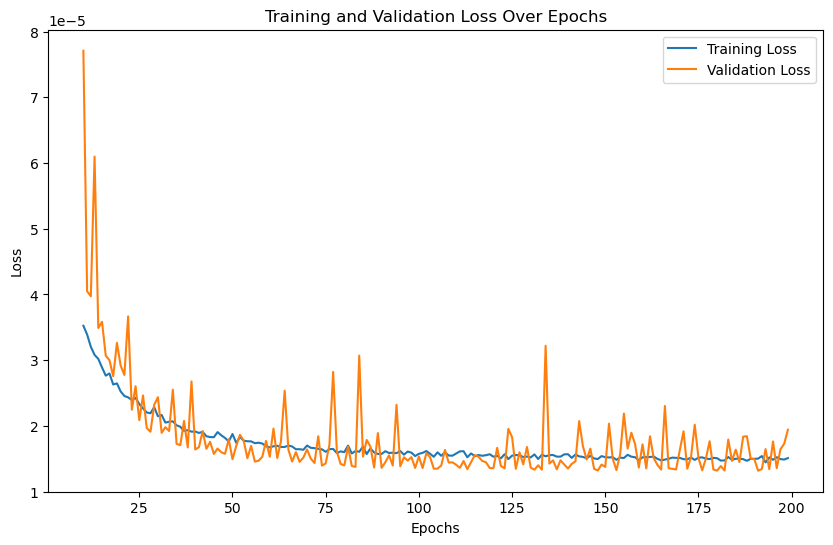

Running model with parameters: {'window_size': 24, 'lstm_dim': 32, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 174.0295, Test MAE: 166.5740
Train MAPE: 0.7345, Test MAPE: 0.3915
Train DA: 47.0377, Test DA: 47.3295
Training Time: 334.4772 seconds, Evaluation Time: 0.1924 seconds



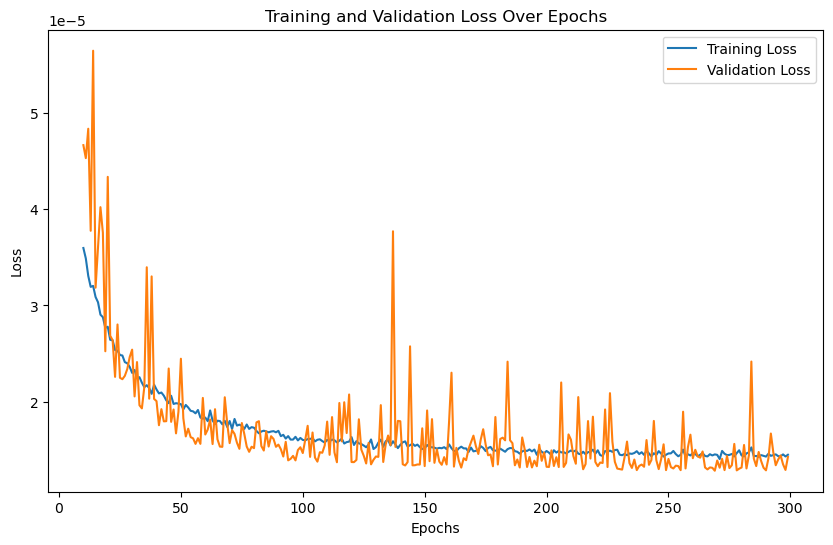

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 142.6894, Test MAE: 145.8857
Train MAPE: 0.4836, Test MAPE: 0.3160
Train DA: 47.1860, Test DA: 46.8932
Training Time: 238.9105 seconds, Evaluation Time: 0.1060 seconds



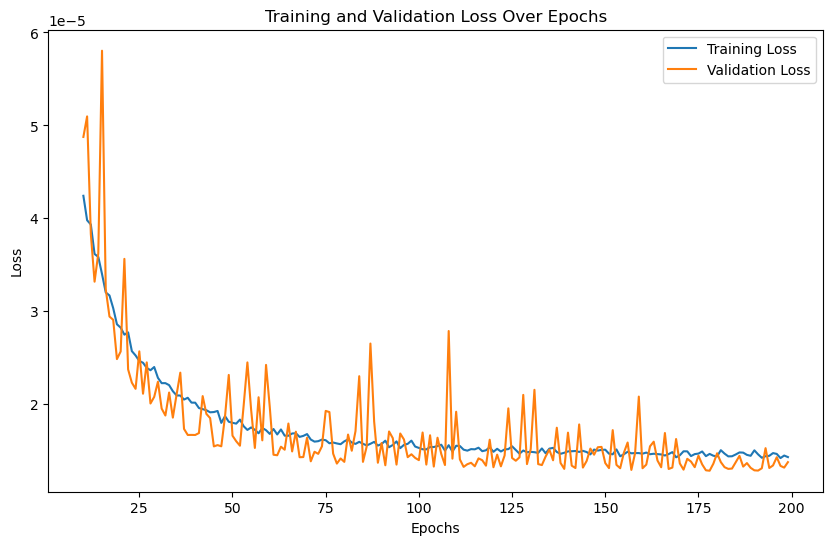

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 140.8320, Test MAE: 138.9043
Train MAPE: 0.4715, Test MAPE: 0.3057
Train DA: 47.0641, Test DA: 47.1576
Training Time: 381.2086 seconds, Evaluation Time: 0.1014 seconds



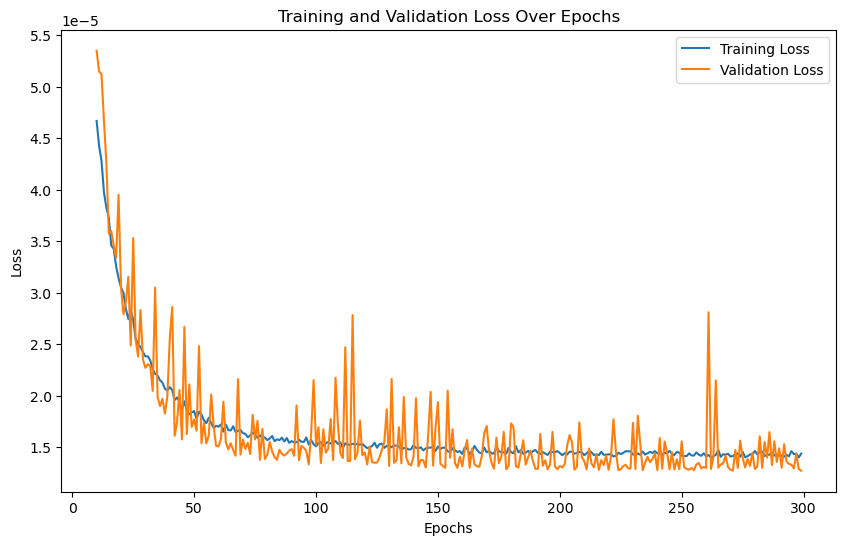

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 146.8202, Test MAE: 142.5658
Train MAPE: 0.5096, Test MAPE: 0.3162
Train DA: 47.1069, Test DA: 47.2105
Training Time: 245.5947 seconds, Evaluation Time: 0.1068 seconds



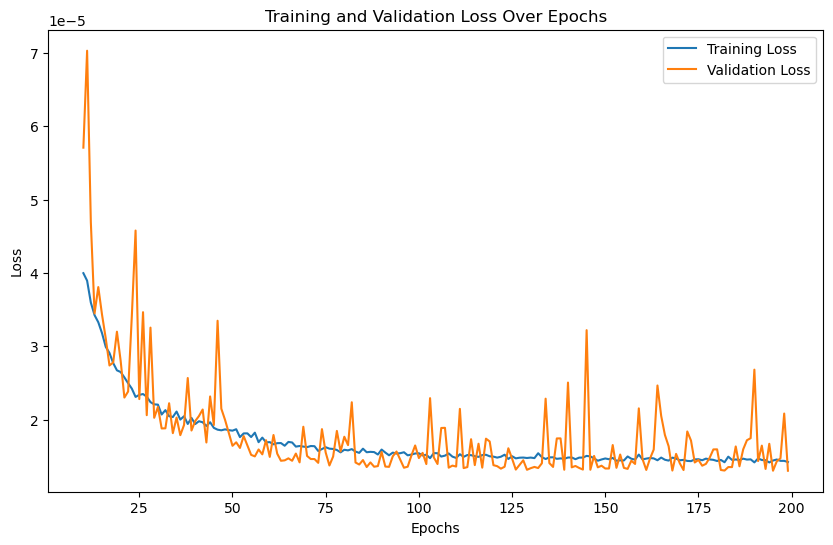

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 142.0571, Test MAE: 146.1982
Train MAPE: 0.4738, Test MAPE: 0.3244
Train DA: 47.0311, Test DA: 47.1444
Training Time: 364.0284 seconds, Evaluation Time: 0.1003 seconds



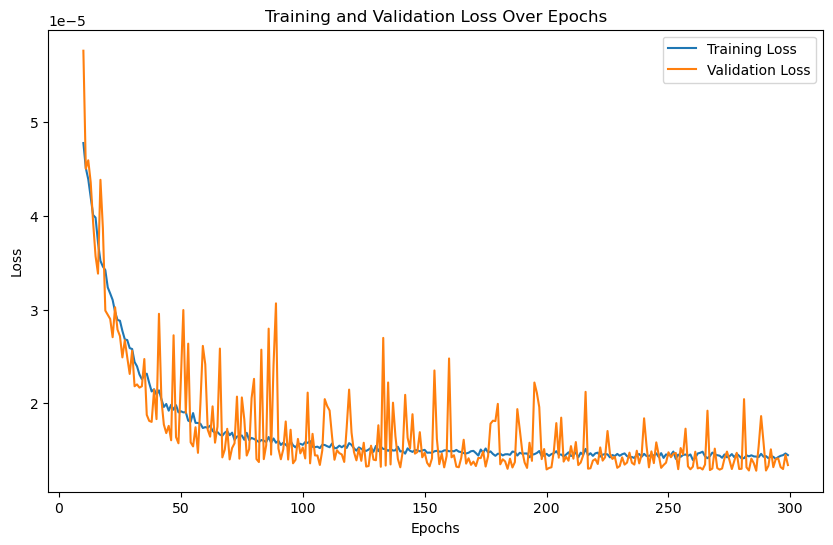

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 175.8952, Test MAE: 152.6165
Train MAPE: 0.7591, Test MAPE: 0.3514
Train DA: 47.1069, Test DA: 47.1973
Training Time: 241.2087 seconds, Evaluation Time: 0.1051 seconds



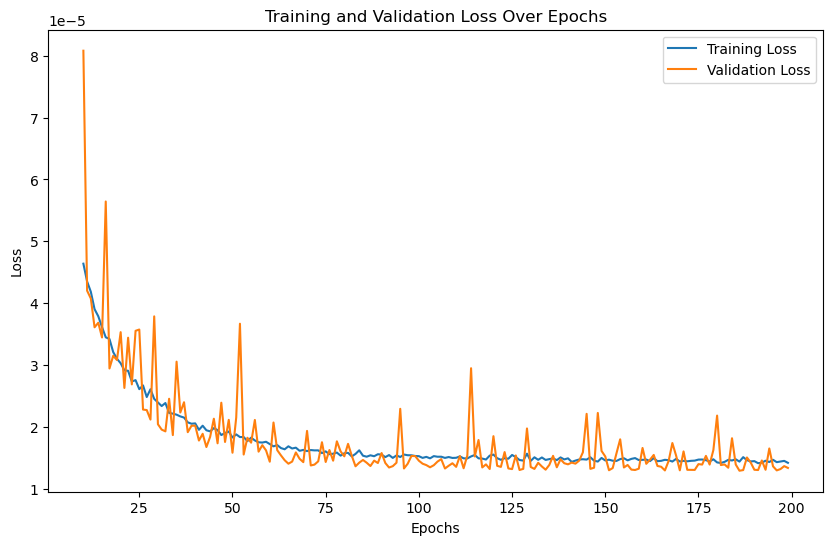

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 172.3970, Test MAE: 186.1508
Train MAPE: 0.6145, Test MAPE: 0.4371
Train DA: 47.0608, Test DA: 47.3295
Training Time: 361.7862 seconds, Evaluation Time: 0.0982 seconds



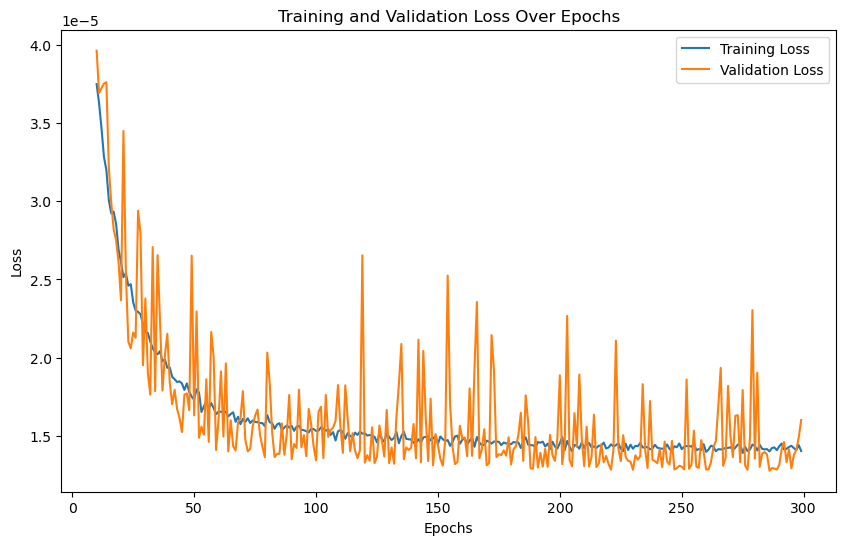

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 161.7301, Test MAE: 155.9462
Train MAPE: 0.6135, Test MAPE: 0.3568
Train DA: 47.0970, Test DA: 46.9989
Training Time: 243.0457 seconds, Evaluation Time: 0.0987 seconds



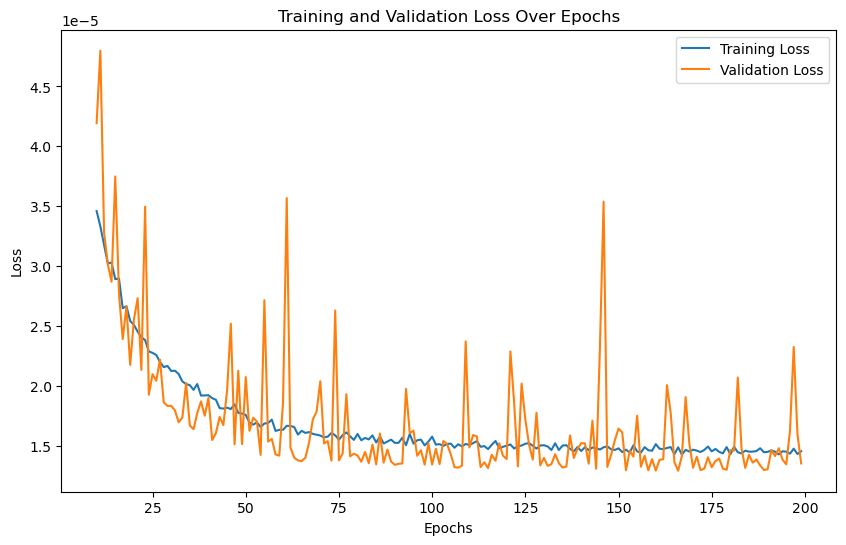

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 143.0721, Test MAE: 142.3529
Train MAPE: 0.4928, Test MAPE: 0.3118
Train DA: 46.9915, Test DA: 47.0650
Training Time: 360.7337 seconds, Evaluation Time: 0.1080 seconds



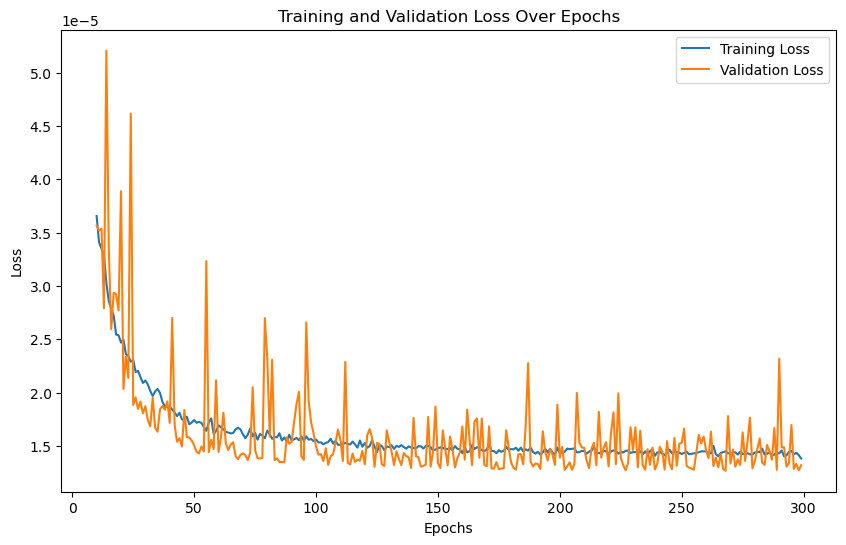

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 156.4247, Test MAE: 145.9310
Train MAPE: 0.6201, Test MAPE: 0.3289
Train DA: 47.2058, Test DA: 46.9196
Training Time: 241.4515 seconds, Evaluation Time: 0.0957 seconds



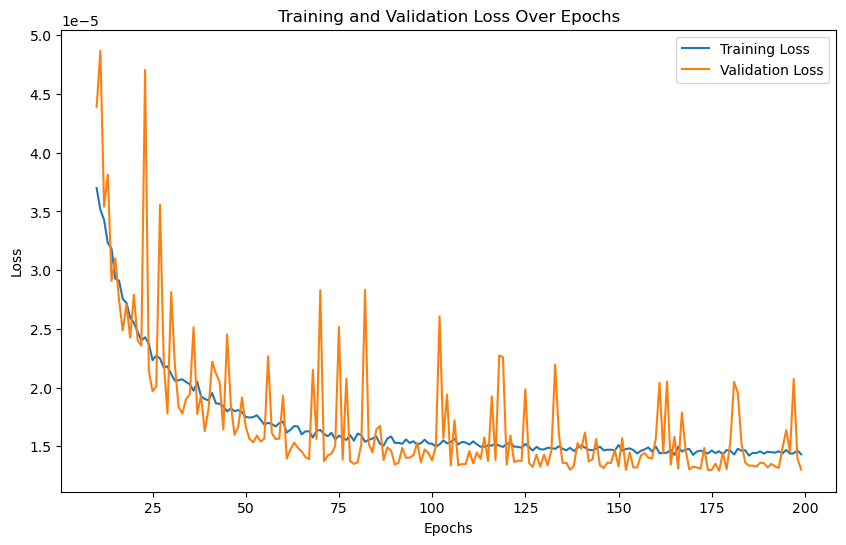

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 149.1120, Test MAE: 138.7990
Train MAPE: 0.5659, Test MAPE: 0.3054
Train DA: 47.0641, Test DA: 47.0915
Training Time: 363.0916 seconds, Evaluation Time: 0.0999 seconds



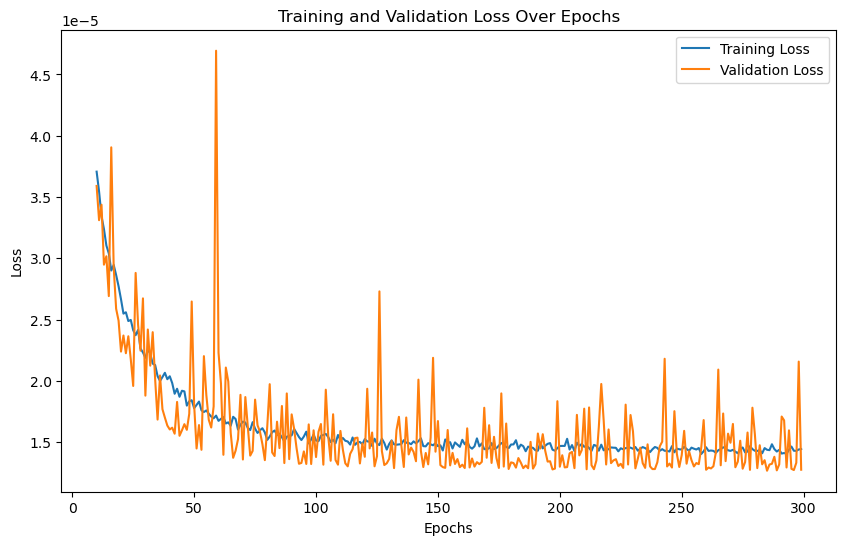

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 146.3248, Test MAE: 144.4681
Train MAPE: 0.5172, Test MAPE: 0.3148
Train DA: 47.2058, Test DA: 47.1179
Training Time: 243.0046 seconds, Evaluation Time: 0.1003 seconds



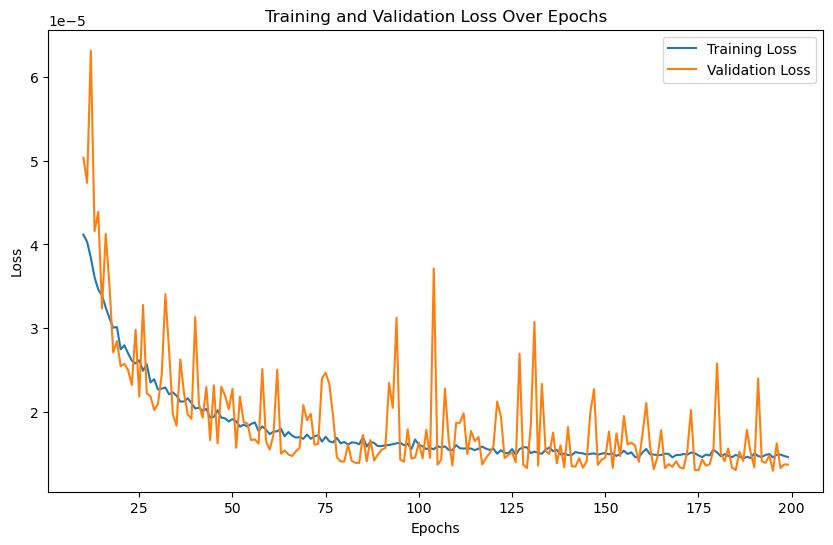

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 167.7445, Test MAE: 172.9242
Train MAPE: 0.6285, Test MAPE: 0.4085
Train DA: 47.0410, Test DA: 47.1179
Training Time: 360.9427 seconds, Evaluation Time: 0.1214 seconds



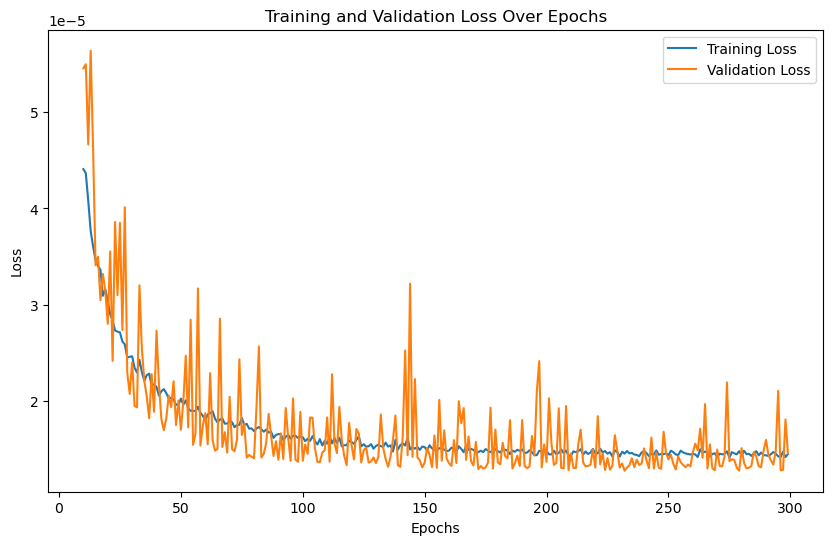

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 152.7684, Test MAE: 150.0270
Train MAPE: 0.5381, Test MAPE: 0.3403
Train DA: 47.3773, Test DA: 47.2369
Training Time: 241.2130 seconds, Evaluation Time: 0.1102 seconds



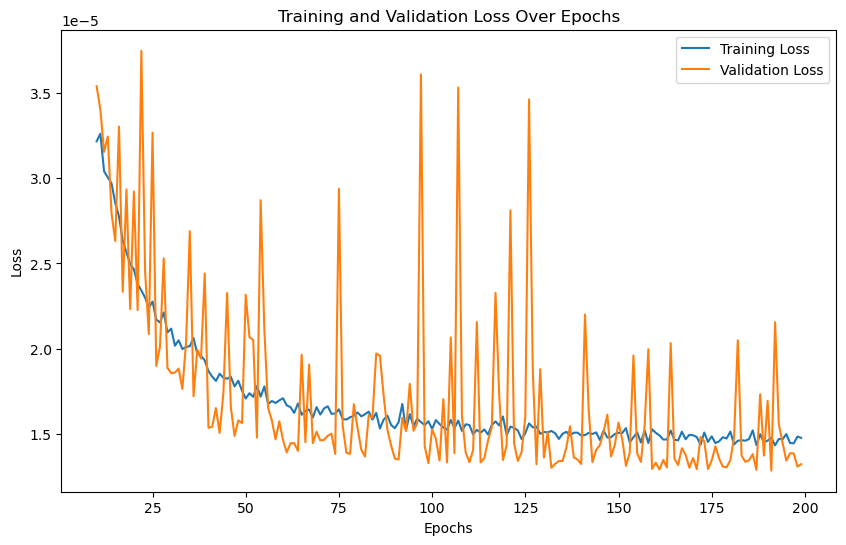

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 182.6210, Test MAE: 170.8934
Train MAPE: 0.7949, Test MAPE: 0.4092
Train DA: 46.9091, Test DA: 47.1576
Training Time: 357.5475 seconds, Evaluation Time: 0.1124 seconds



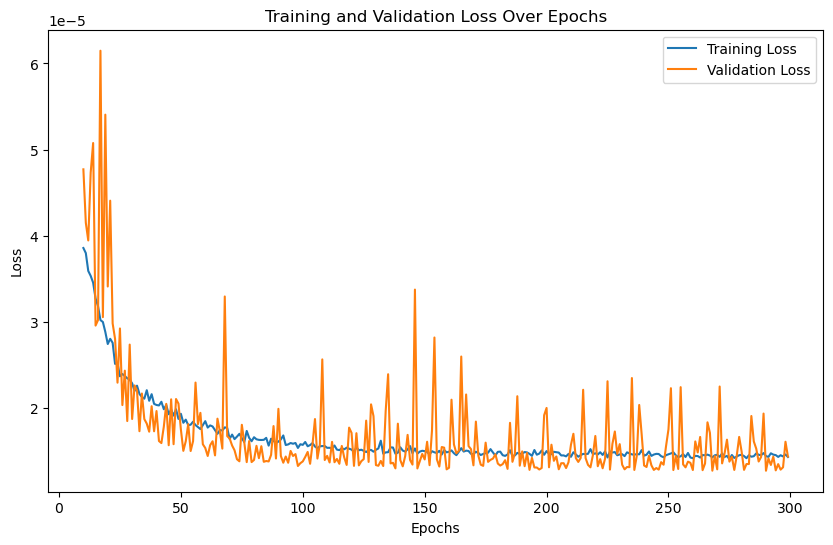

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 164.9923, Test MAE: 159.4151
Train MAPE: 0.6340, Test MAPE: 0.3711
Train DA: 47.0080, Test DA: 47.0518
Training Time: 237.7370 seconds, Evaluation Time: 0.1067 seconds



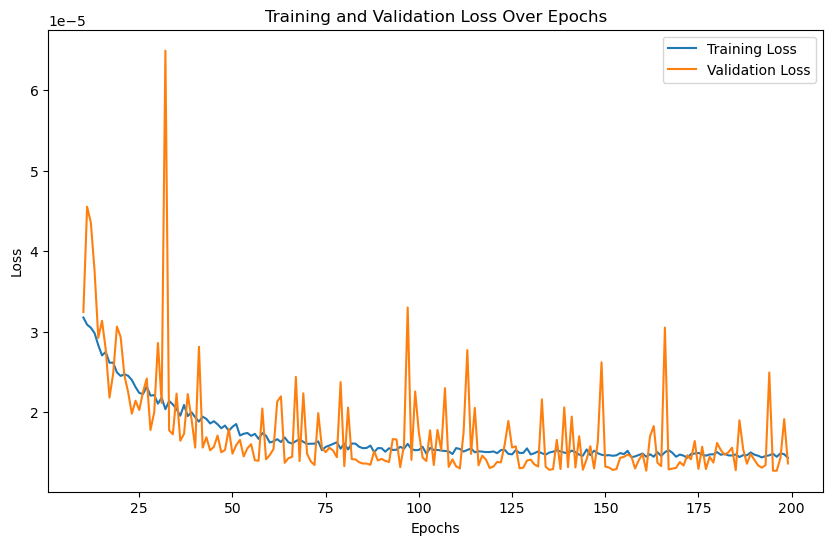

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 143.8483, Test MAE: 150.8833
Train MAPE: 0.4796, Test MAPE: 0.3372
Train DA: 46.9948, Test DA: 47.1708
Training Time: 354.1530 seconds, Evaluation Time: 0.1096 seconds



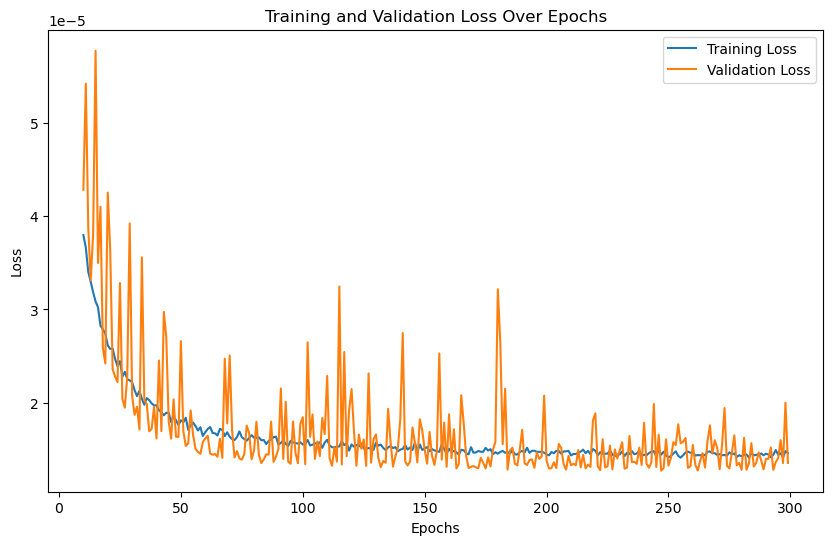

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 142.6516, Test MAE: 139.1935
Train MAPE: 0.4829, Test MAPE: 0.3063
Train DA: 47.0410, Test DA: 46.9857
Training Time: 238.6113 seconds, Evaluation Time: 0.1111 seconds



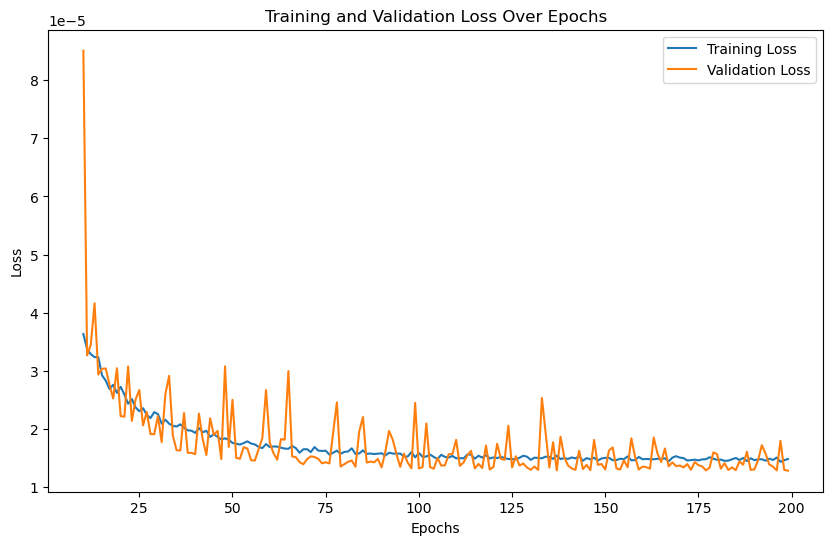

Running model with parameters: {'window_size': 24, 'lstm_dim': 64, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 140.0841, Test MAE: 139.9058
Train MAPE: 0.4668, Test MAPE: 0.3090
Train DA: 47.0212, Test DA: 47.0254
Training Time: 354.8341 seconds, Evaluation Time: 0.1281 seconds



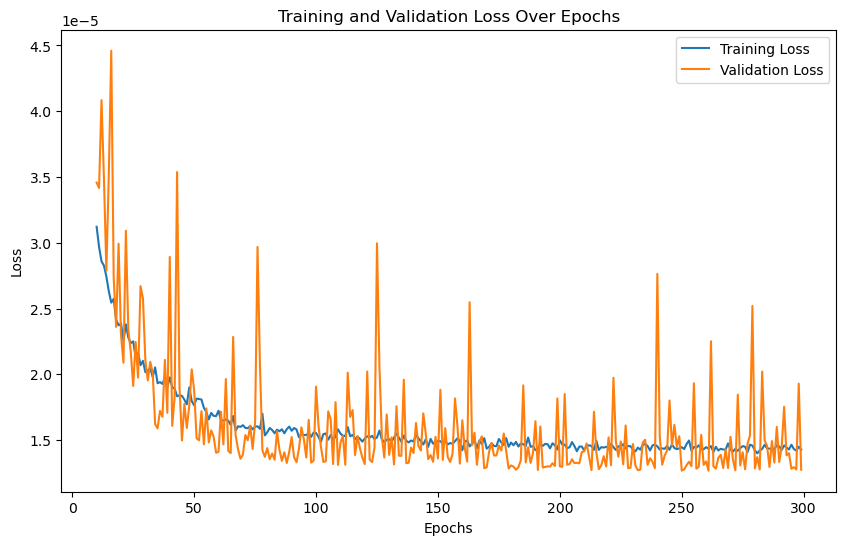

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 140.3628, Test MAE: 142.4268
Train MAPE: 0.4676, Test MAPE: 0.3102
Train DA: 46.9783, Test DA: 47.2369
Training Time: 233.9229 seconds, Evaluation Time: 0.1922 seconds



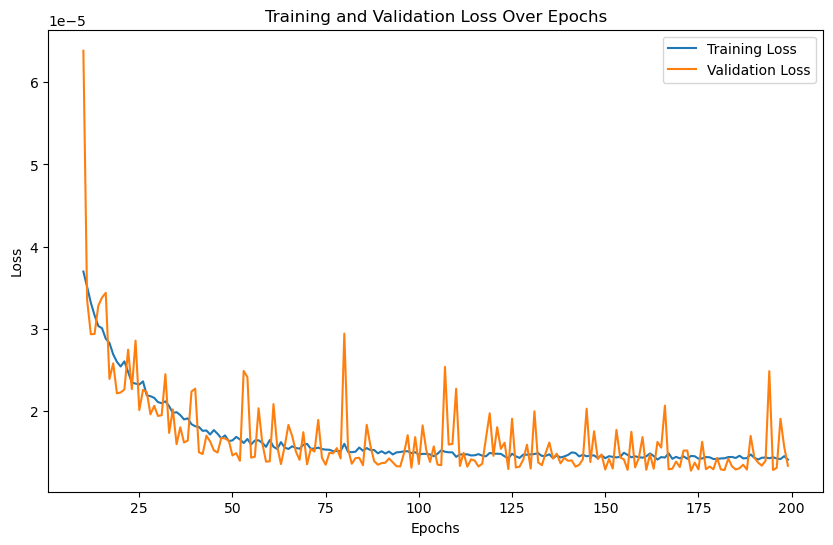

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 228.9549, Test MAE: 267.3731
Train MAPE: 0.8220, Test MAPE: 0.6566
Train DA: 47.1399, Test DA: 47.0650
Training Time: 351.6903 seconds, Evaluation Time: 0.1976 seconds



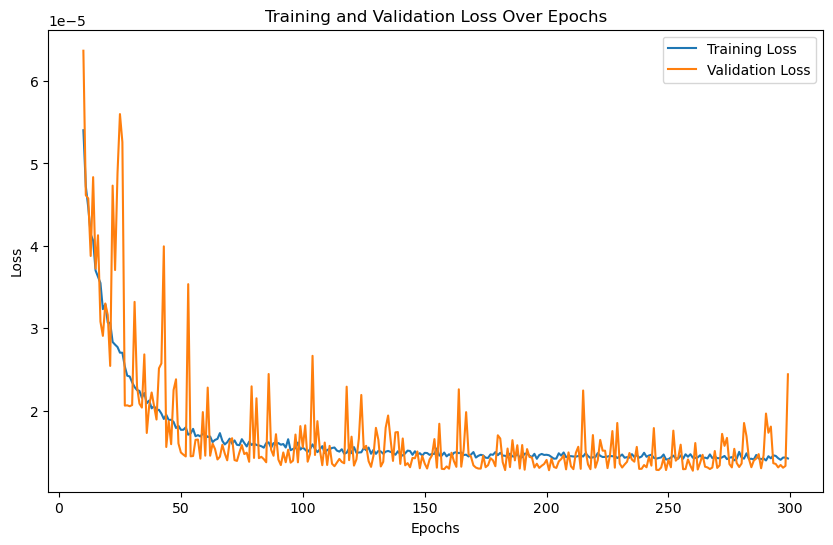

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 145.9809, Test MAE: 138.8752
Train MAPE: 0.5142, Test MAPE: 0.3052
Train DA: 47.0805, Test DA: 47.1047
Training Time: 234.1857 seconds, Evaluation Time: 0.1906 seconds



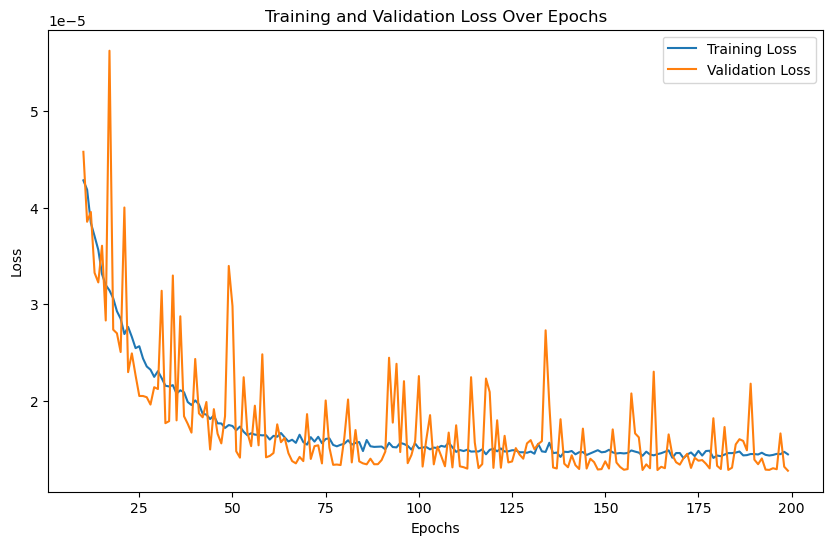

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 154.5410, Test MAE: 148.6801
Train MAPE: 0.6014, Test MAPE: 0.3308
Train DA: 47.0772, Test DA: 46.9196
Training Time: 352.0035 seconds, Evaluation Time: 0.1899 seconds



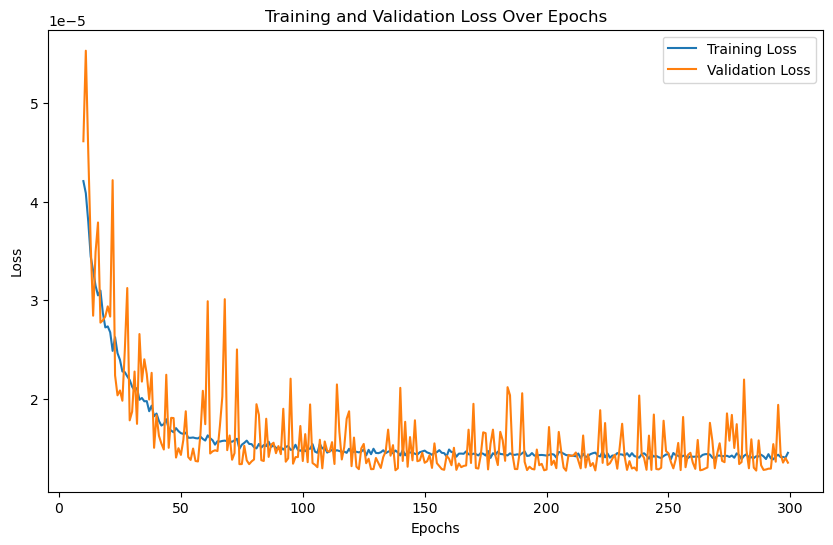

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 151.4430, Test MAE: 156.0964
Train MAPE: 0.5254, Test MAPE: 0.3596
Train DA: 46.9750, Test DA: 47.2105
Training Time: 234.3206 seconds, Evaluation Time: 0.1989 seconds



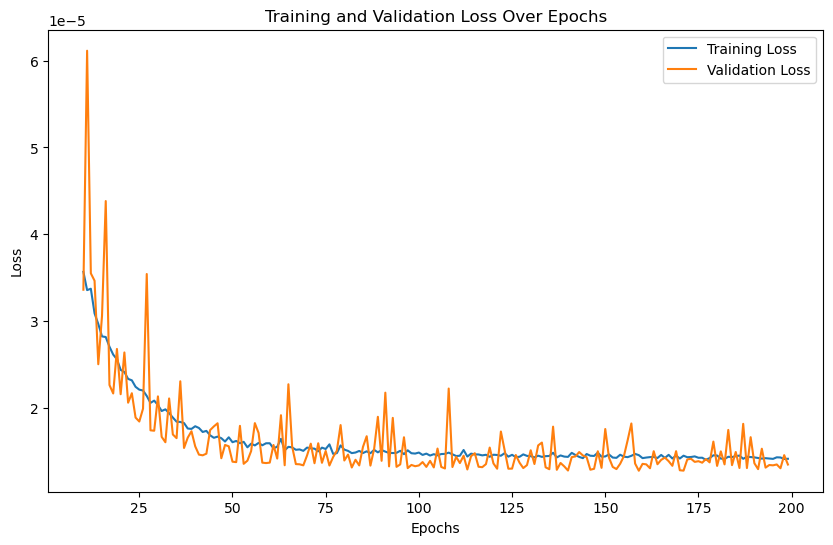

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 32, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 163.9733, Test MAE: 182.1707
Train MAPE: 0.6069, Test MAPE: 0.4243
Train DA: 47.0278, Test DA: 46.9857
Training Time: 352.8011 seconds, Evaluation Time: 0.2099 seconds



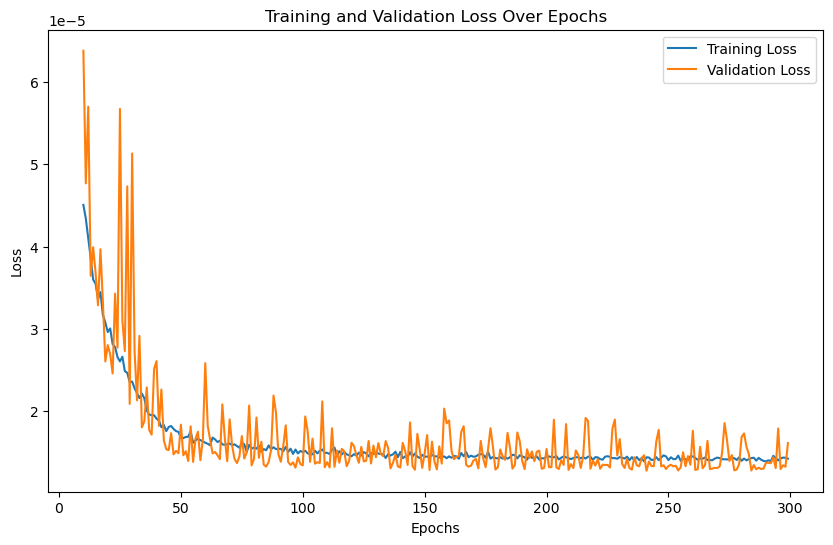

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 147.7417, Test MAE: 146.3889
Train MAPE: 0.5216, Test MAPE: 0.3294
Train DA: 46.9750, Test DA: 47.3162
Training Time: 238.3262 seconds, Evaluation Time: 0.2116 seconds



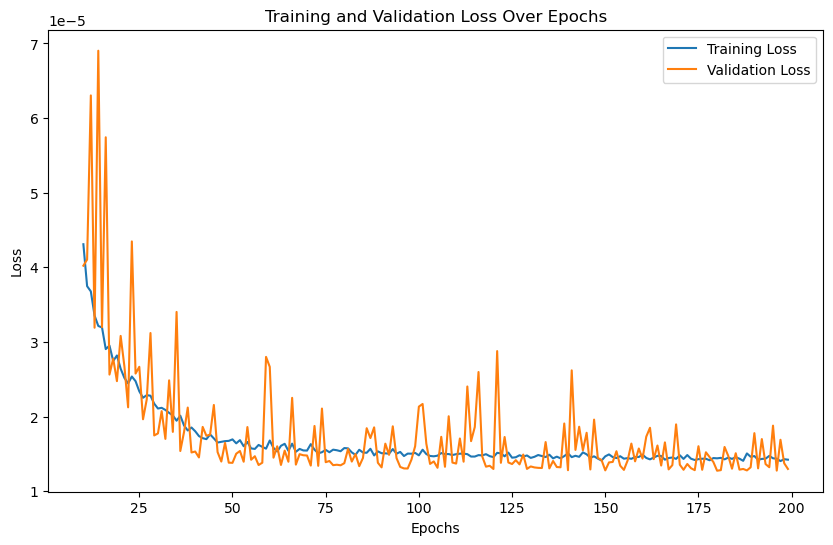

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 143.1507, Test MAE: 149.4095
Train MAPE: 0.4831, Test MAPE: 0.3378
Train DA: 47.0311, Test DA: 46.7610
Training Time: 384.4555 seconds, Evaluation Time: 0.2057 seconds



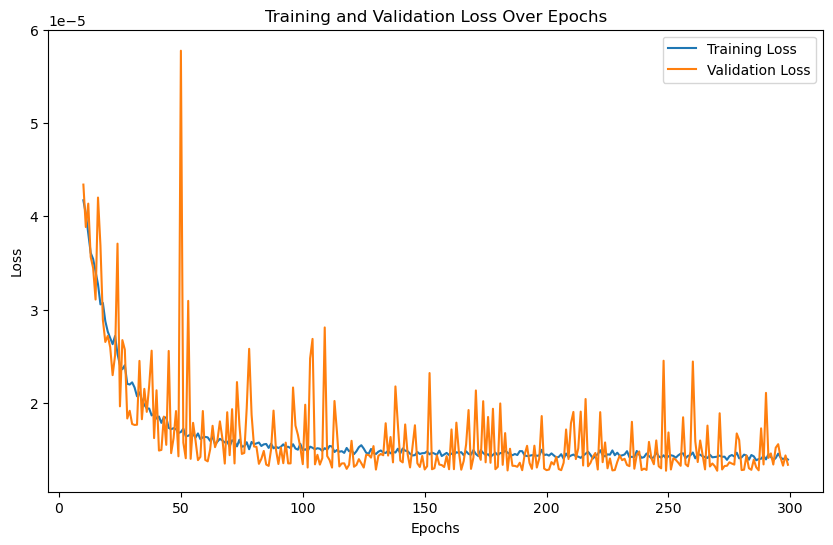

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 157.9194, Test MAE: 153.5943
Train MAPE: 0.5709, Test MAPE: 0.3430
Train DA: 47.0344, Test DA: 46.9461
Training Time: 255.2624 seconds, Evaluation Time: 0.2031 seconds



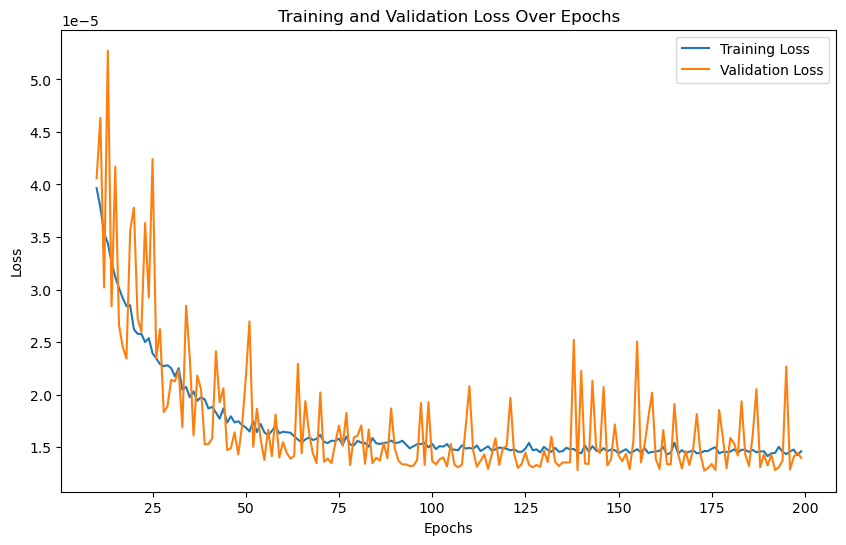

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 147.4457, Test MAE: 158.5673
Train MAPE: 0.5015, Test MAPE: 0.3622
Train DA: 47.0179, Test DA: 46.8667
Training Time: 386.5421 seconds, Evaluation Time: 0.2029 seconds



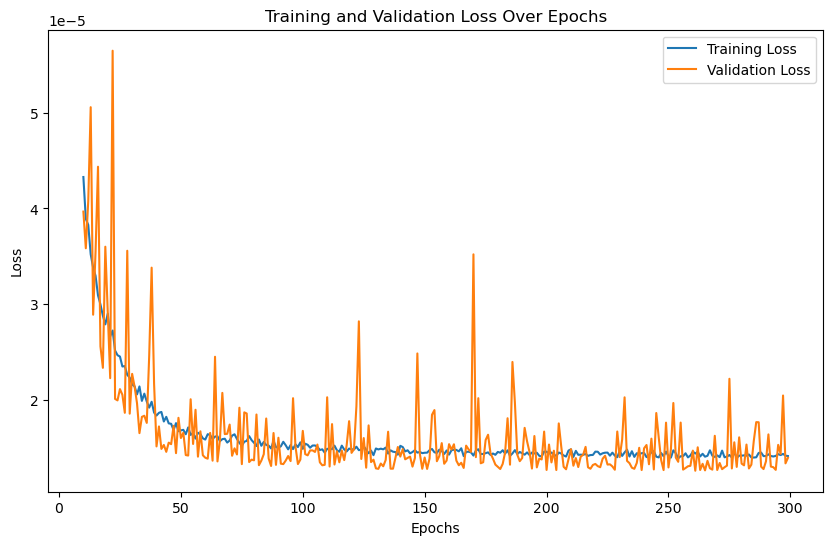

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 158.0381, Test MAE: 141.8956
Train MAPE: 0.6271, Test MAPE: 0.3145
Train DA: 47.1003, Test DA: 47.1179
Training Time: 251.6101 seconds, Evaluation Time: 0.1995 seconds



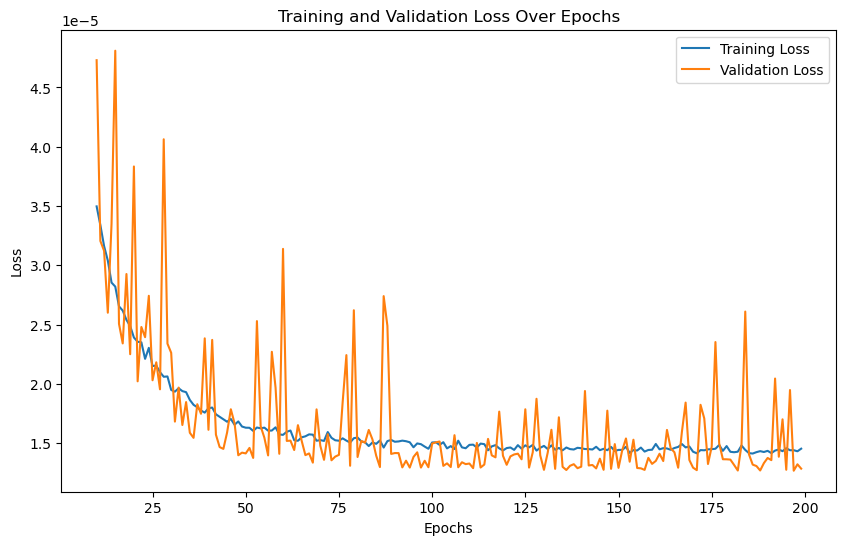

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 64, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 140.4548, Test MAE: 139.1803
Train MAPE: 0.4673, Test MAPE: 0.3064
Train DA: 46.9256, Test DA: 47.1708
Training Time: 364.5509 seconds, Evaluation Time: 0.2087 seconds



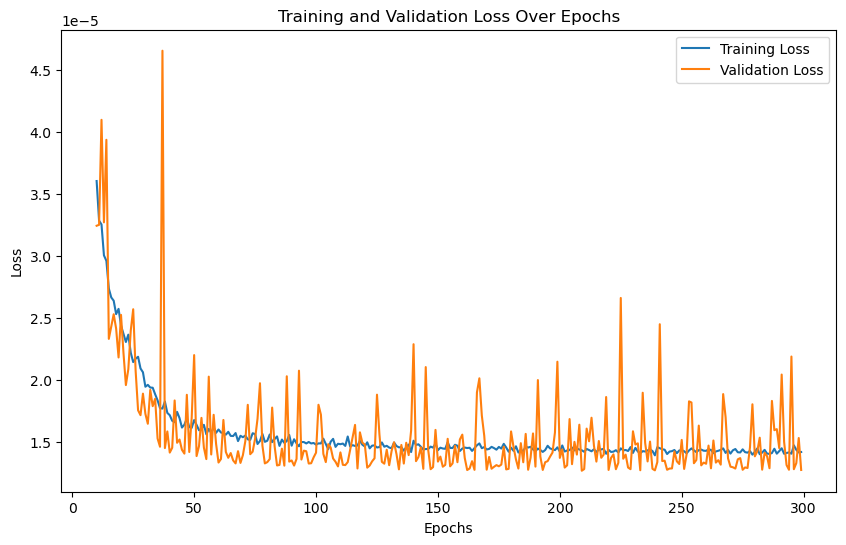

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 153.5769, Test MAE: 160.4757
Train MAPE: 0.5231, Test MAPE: 0.3690
Train DA: 46.9487, Test DA: 46.9725
Training Time: 240.7131 seconds, Evaluation Time: 0.2140 seconds



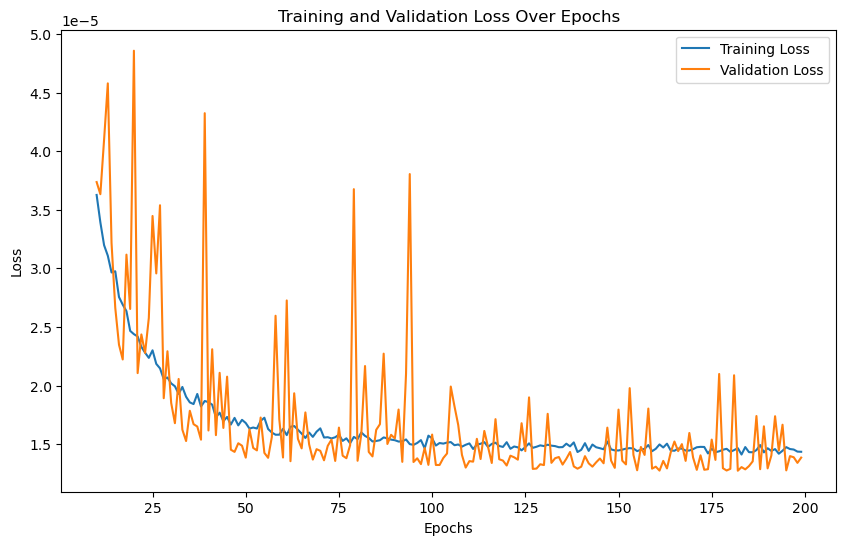

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.0, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 140.9637, Test MAE: 142.9839
Train MAPE: 0.4765, Test MAPE: 0.3124
Train DA: 47.0871, Test DA: 46.9064
Training Time: 381.8600 seconds, Evaluation Time: 0.2014 seconds



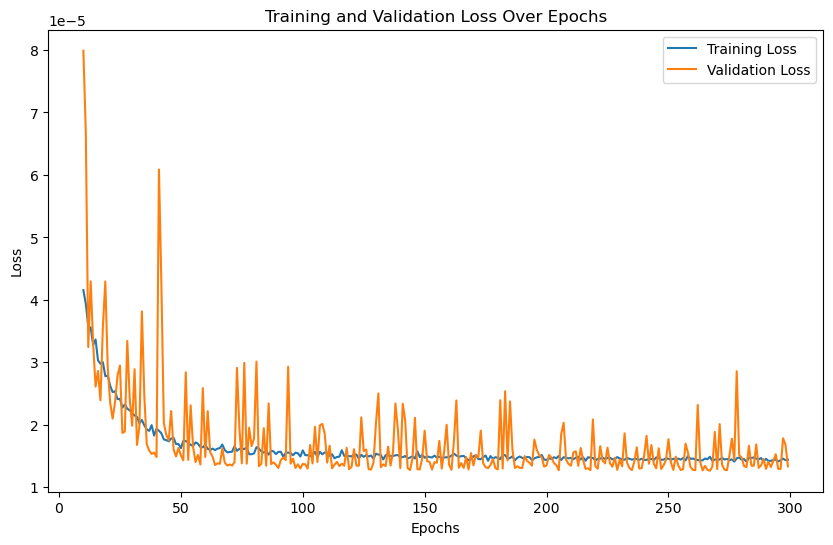

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 152.3265, Test MAE: 142.4992
Train MAPE: 0.5825, Test MAPE: 0.3178
Train DA: 46.9091, Test DA: 46.7874
Training Time: 328.0728 seconds, Evaluation Time: 8.7830 seconds



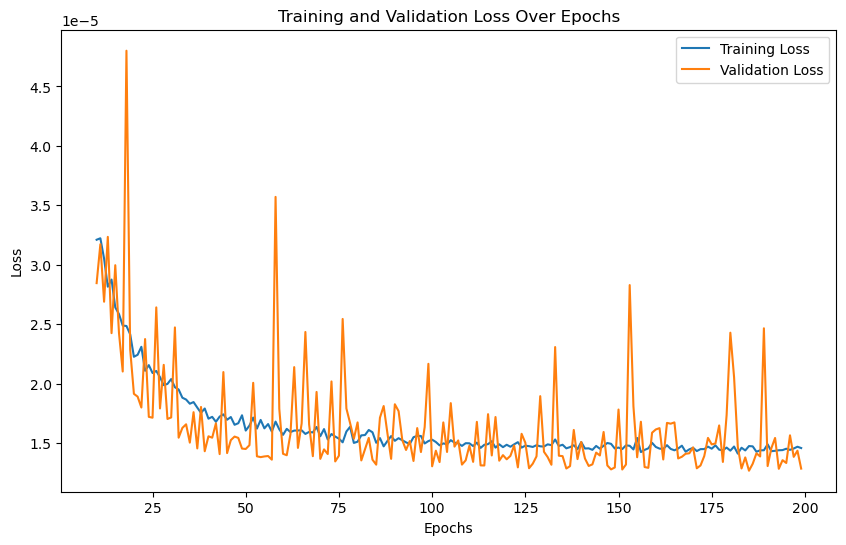

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.05, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 147.4038, Test MAE: 144.7390
Train MAPE: 0.5185, Test MAPE: 0.3173
Train DA: 46.9882, Test DA: 47.0254
Training Time: 426.8805 seconds, Evaluation Time: 0.3276 seconds



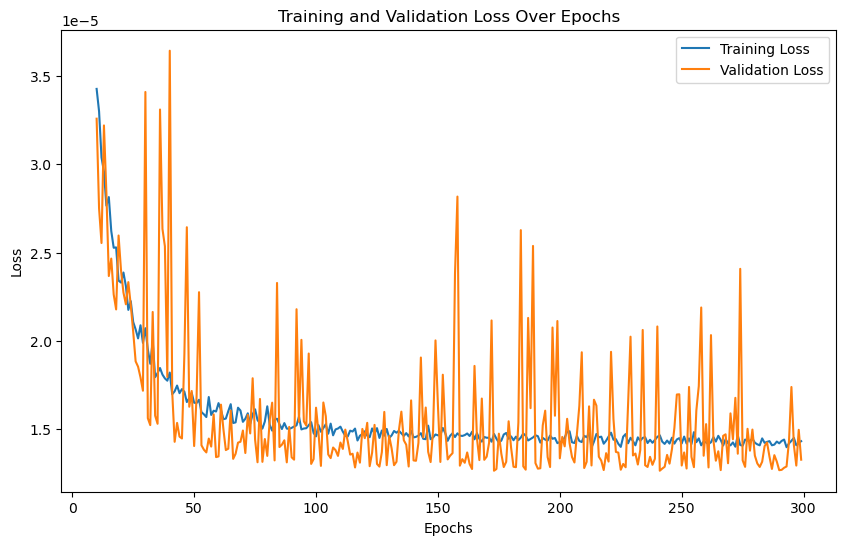

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 200, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 151.0128, Test MAE: 156.3434
Train MAPE: 0.5016, Test MAPE: 0.3520
Train DA: 47.0476, Test DA: 47.1576
Training Time: 278.6390 seconds, Evaluation Time: 0.5662 seconds



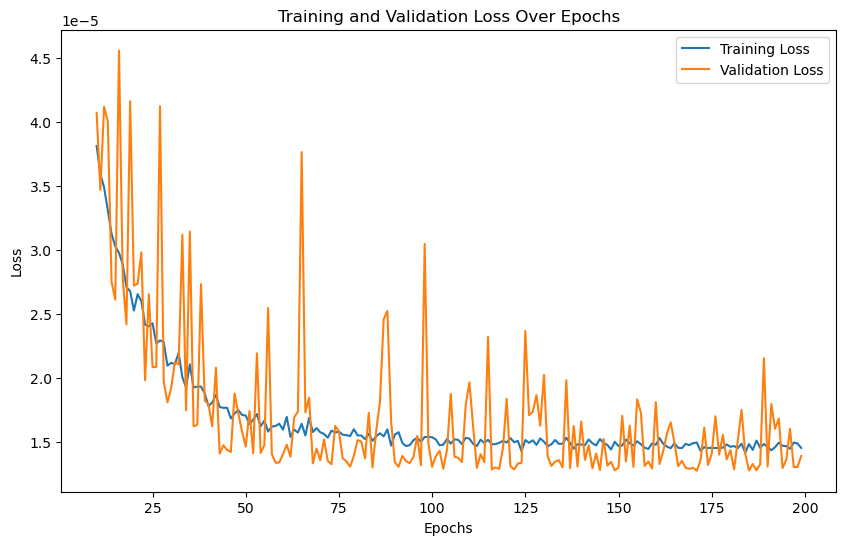

Running model with parameters: {'window_size': 24, 'lstm_dim': 128, 'dense_dim1': 128, 'dense_dim2': 32, 'num_layers': 1, 'dropout': 0.1, 'lr': 0.0001, 'num_epochs': 300, 'batch_size': 64, 'optimizer_type': 'Adam', 'patience': 24, 'activation_function': <class 'torch.nn.modules.activation.Tanh'>}

Results: Train MAE: 155.8742, Test MAE: 141.6934
Train MAPE: 0.6145, Test MAPE: 0.3142
Train DA: 46.9948, Test DA: 47.1444
Training Time: 443.7054 seconds, Evaluation Time: 9.0762 seconds



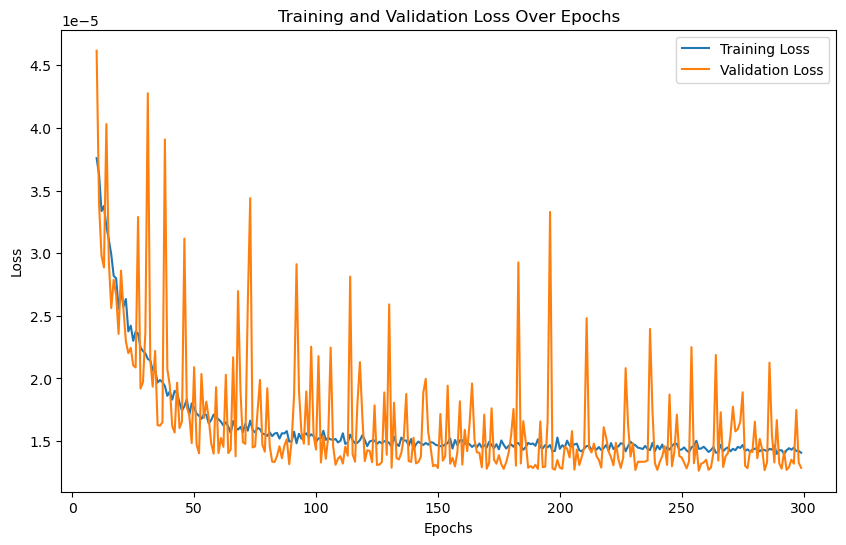

Total time taken: 16317.47305727005 seconds


Press Enter to stop the beep sound... 


Beep sound stopped.


In [41]:
# Start total timer
start = time.time()

# Grid search
for params in itertools.product(*parameter_space.values()):
    param_dict = dict(zip(parameter_space.keys(), params))
    print(f"Running model with parameters: {param_dict}\n")
    # Run with fixed epochs
    train_and_evaluate(df, target_column=target_column, feature_columns=features, params=param_dict, file_prefix='results_complete15', use_early_stopping=False, plot_loss=True)


# Calculate total time
end = time.time()
total_time = end - start

# Print the total time taken
print(f"Total time taken: {total_time} seconds")

# Function to play a beep sound in a loop
def play_beep():
    while not stop_beep_flag:
        winsound.Beep(2000, 600)
        time.sleep(0.7)
        
# Start the beep sound
stop_beep_flag = False
beep_thread = Thread(target=play_beep)
beep_thread.start()

input("Press Enter to stop the beep sound...")
stop_beep_flag = True
beep_thread.join()
print("Beep sound stopped.")